# Behind The MovieLens: Using Machine Learning to Make Movie Recommendations

INFO-I 526 Indiana University

Govil Kumar, Anand Sriramulu, Sam Bell


## Introductory step: Libraries and data

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
import seaborn as sns
import warnings
warnings.simplefilter('ignore')

from collections import Counter
from scipy import sparse, stats
from sklearn import preprocessing as prep
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso, LinearRegression, LogisticRegression, Ridge, SGDClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, ShuffleSplit, StratifiedKFold
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import Imputer, LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.svm import SVC, SVR
from sklearn.utils import check_array
from time import time

The MovieLens dataset has four data files:

•	movies has information about the movies, including name, year of release, and genres;

•	links contains information for linking each movie to Internet Movie Database (IMDB) and The Movie Database (TMDB), which are two popular online movie databases;

•	ratings is a time-stamped record of each individual user’s movie ratings, on a scale of ½ star to 5 stars;

•	tags is a collection of user-applied tag applications for each movie. 

In [4]:
links_small = pd.read_csv('./ml_small/links.csv')
movies_small = pd.read_csv('./ml_small/movies.csv')
ratings_small = pd.read_csv('./ml_small/ratings.csv')
tags_small = pd.read_csv('./ml_small/tags.csv')

# EDA

We'll start with ratings. This is the dataset we'll use for the first area of focus, Collaborative Learning. The "small" data set has about 100,000 ratimgs:

## Ratings

In [4]:
ratings_small.shape

(100836, 4)

In [5]:
ratings_small.head(10)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


Each row is one user's rating of one movie. Let's join it to the movies dataset so we can see which movies they are:

In [7]:
pd.merge(ratings_small.head(10), movies_small)

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
5,1,70,3.0,964982400,From Dusk Till Dawn (1996),Action|Comedy|Horror|Thriller
6,1,101,5.0,964980868,Bottle Rocket (1996),Adventure|Comedy|Crime|Romance
7,1,110,4.0,964982176,Braveheart (1995),Action|Drama|War
8,1,151,5.0,964984041,Rob Roy (1995),Action|Drama|Romance|War
9,1,157,5.0,964984100,Canadian Bacon (1995),Comedy|War


The small data set includes only users who have rated at least 20 movies. Most users don't rate very many movies, but there are some "power users" who rate thousands.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb99b1858d0>]],
      dtype=object)

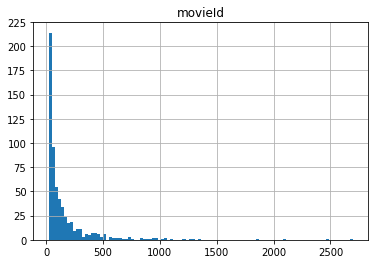

In [8]:
%matplotlib inline
ratings_small[['userId','movieId']].groupby('userId').agg('count').hist(bins = 100)

Similarly, most movies have very few ratings, but there are some very popular ones:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb99ae606a0>]],
      dtype=object)

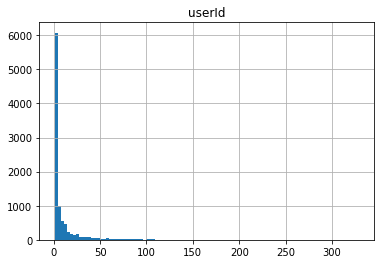

In [9]:
ratings_small[['userId','movieId']].groupby('movieId').agg('count').hist(bins = 100)

Here are the 25 most popular movies with their average rating:

In [10]:
mdata = ratings_small[['movieId','rating']].groupby('movieId').agg(['count', 'mean'])['rating']
pd.merge(movies_small, mdata, left_on = 'movieId', right_on = 'movieId').nlargest(25, 'count')

,movieId,title,genres,count,mean
314,356,Forrest Gump (1994),Comedy|Drama|Romance|War,329,4.164134
277,318,"Shawshank Redemption, The (1994)",Crime|Drama,317,4.429022
257,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,307,4.197068
510,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,279,4.161290
1938,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,278,4.192446
224,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,251,4.231076
418,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,238,3.750000
97,110,Braveheart (1995),Action|Drama|War,237,4.031646
507,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi,224,3.970982
461,527,Schindler's List (1993),Drama|War,220,4.225000


One thing we've noticed is that users tend to mostly rate movies they like. The most popular rating is four stars out of five:

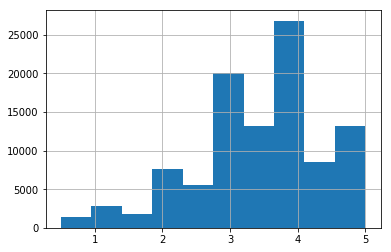

In [16]:
ratings_small['rating'].hist()

<b> Visualize how the "Mean" Rating is distributed </b>

We notice that most of it is distributed in the middle somewhere between 2.6 to 4.3 approx


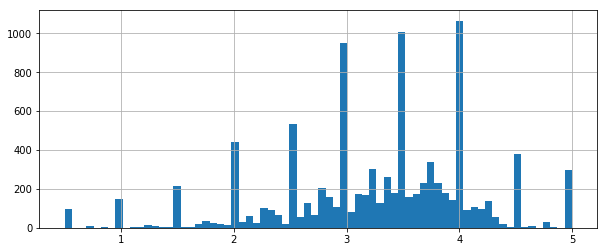

In [11]:
rtngs = pd.merge(movies_small, mdata, left_on = 'movieId', right_on = 'movieId')
plt.figure(figsize=(10,4))
rtngs['mean'].hist(bins=70)

<b> Checking the Trend how the Rating tend to move with contrast to Count</b>

We see there is an upward trend which says that as more individual like the movie the higher the rating tend to go

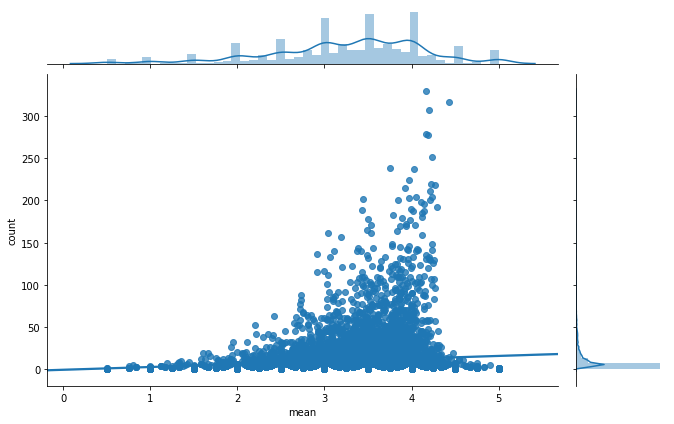

In [191]:
my_plot = sns.jointplot(x='mean',y='count',data=rtngs,kind="reg")
my_plot.fig.set_figwidth(10)

## Movies

Let's break down the genres and one-hot encode them:

In [12]:
df = movies_small[['movieId', 'genres']]
dummies = pd.get_dummies(movies_small['genres'])

atom_col = [c for c in dummies.columns if '|' not in c]

for col in atom_col:
    df[col] = dummies[[c for c in dummies.columns if col in c]].sum(axis=1)

df.head(10)

,movieId,genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,1,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1,2,Adventure|Children|Fantasy,0,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,3,Comedy|Romance,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Comedy|Drama|Romance,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Comedy,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,6,Action|Crime|Thriller,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
6,7,Comedy|Romance,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
7,8,Adventure|Children,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,9,Action,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,10,Action|Adventure|Thriller,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Let's see how the genres are correlated with each other:

In [39]:
df.corr()

,movieId,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,1.000000,0.130199,0.059174,0.036144,0.165465,0.014081,0.020028,-0.021733,0.063766,-0.109353,0.049587,-0.050462,0.003763,-0.069510,-0.011663,-0.096111,0.058163,-0.004188,-0.048694,-0.033304
(no genres listed),0.130199,1.000000,-0.028442,-0.022840,-0.015309,-0.016005,-0.046878,-0.022171,-0.012871,-0.053277,-0.017447,-0.005618,-0.019769,-0.011151,-0.014794,-0.026195,-0.019792,-0.029073,-0.011956,-0.007816
Action,0.059174,-0.028442,1.000000,0.291949,0.029659,-0.049652,-0.148968,0.154471,-0.099463,-0.152964,0.059931,-0.031649,-0.035443,-0.083331,-0.028515,-0.146670,0.233475,0.199042,0.076289,0.021600
Adventure,0.036144,-0.022840,0.291949,1.000000,0.211472,0.273931,-0.055215,-0.085988,-0.075111,-0.156327,0.262511,-0.030140,-0.098423,-0.005544,-0.048427,-0.072584,0.181797,-0.035942,0.010195,0.036136
Animation,0.165465,-0.015309,0.029659,0.211472,1.000000,0.437376,0.029079,-0.069847,-0.050144,-0.160504,0.196895,-0.015555,-0.062464,0.111804,-0.030477,-0.061882,0.064093,-0.107822,-0.036990,-0.024378
Children,0.014081,-0.016005,-0.049652,0.273931,0.437376,1.000000,0.088701,-0.086442,-0.056859,-0.160742,0.234117,-0.025673,-0.083569,0.137072,-0.036449,-0.070189,-0.011910,-0.127716,-0.048341,-0.016890
Comedy,0.020028,-0.046878,-0.148968,-0.055215,0.029079,0.088701,1.000000,-0.075282,-0.131657,-0.283472,-0.005708,-0.070710,-0.133382,0.045466,-0.127209,0.153088,-0.132400,-0.286289,-0.095919,-0.039622
Crime,-0.021733,-0.022171,0.154471,-0.085988,-0.069847,-0.086442,-0.075282,1.000000,-0.073955,0.063005,-0.086254,0.137141,-0.063805,-0.056850,0.124138,-0.097444,-0.095166,0.265196,-0.059585,-0.022997
Documentary,0.063766,-0.012871,-0.099463,-0.075111,-0.050144,-0.056859,-0.131657,-0.073955,1.000000,-0.173925,-0.060473,-0.020645,-0.069364,-0.005664,-0.050168,-0.093597,-0.072736,-0.104346,-0.013378,-0.024915
Drama,-0.109353,-0.053277,-0.152964,-0.156327,-0.160504,-0.160742,-0.283472,0.063005,-0.173925,1.000000,-0.106337,0.024256,-0.187391,-0.038022,0.027635,0.122454,-0.158325,-0.008267,0.135067,-0.025060


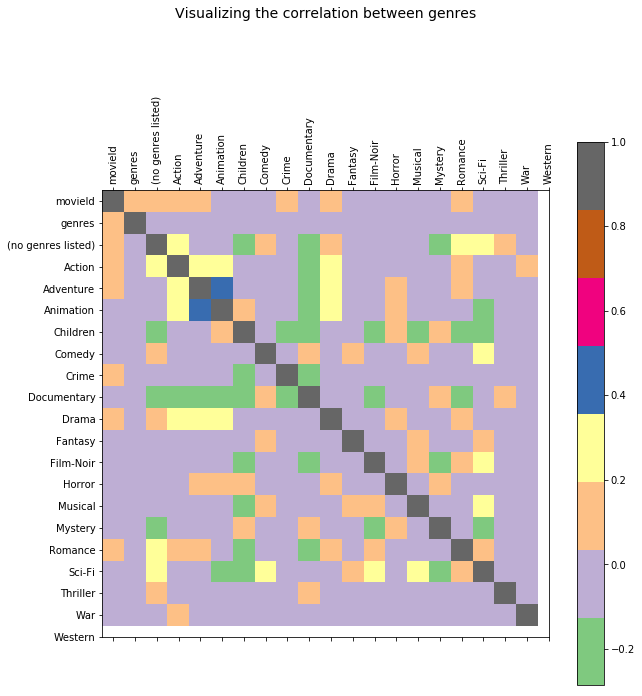

In [40]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ms = ax.matshow(df.corr(),cmap='Accent') # 'hot','copper') #interpolation='nearest')
fig.colorbar(ms)
label_count = list(range(len(df.columns)))
ax.set_xticks(label_count)
ax.set_xticklabels(df.columns, rotation=90)
ax.set_yticks(label_count)
ax.set_yticklabels(df.columns)
ax.set_title('Visualizing the correlation between genres', pad=150, fontsize=14);

Some things we can notice about this data:

Documentary is negatively correlated with many genres, including Action, Adventur, Comedy, Children, Romance. This is because documentarys tend not to overlap with these genres.

Animiation and Adventure are positively correlated.

There aren't many Comedy Film-Noir movies or Children's Romance movies.



## Links

We can use the links data to get IMDB or TMDB data.

In [17]:
#first let's clean NAs
links_small["tmdbId"] = links_small["tmdbId"].fillna(-1).astype(int)

In [18]:
for x in links_small[0:5]["tmdbId"]:
    movies = tmdb.Movies(x) 
    response = movies.info()
    print(movies.original_title)
    print(movies.budget)
    print(movies.runtime)
    print(movies.vote_average)
    print(movies.vote_count)
    print(movies.revenue)
    print(movies.release_date)
    print('------')

NameError: name 'tmdb' is not defined

# Collaborative Filtering

We are going to explore three methods for building a prediction. 

•	User-Item Collaborative Filtering: To make recommendations for a particular user, find other users who are similar, and look at what items they rated highly

•	Item-Item Collaborative Filtering: Similar to user-item, except instead of similar users, we are looking for similar items.

•	Content-based recommendation. This involves making comparisons based on metadata, such as tags. For example, if a user has a history of giving high ratings to movies tagged “comedy”, show that user more movies tagged “comedy”. We can use the MovieLens “tags” dataset for this.



We'll start with the first, user-item.

## User - Item CF

This method is similar to K-Nearest neighbors collaboration. To predict a score for a particulatr user, we will find some number k of users who are similar to that user, and average their ratings for that movie.

### Example

To find similar users to user id 1, let's look for users who rated the same movies above 4.

In [16]:
other_user_rating = pd.merge(ratings_small.loc[(ratings_small['userId'] == 1) 
                                               & (ratings_small['rating'] >= 4)]
         , ratings_small.loc[(ratings_small['userId'] != 1) 
                             & (ratings_small['rating'] >= 4)]
                             , on='movieId')

other_user_rating.head(10)

,userId_x,movieId,rating_x,timestamp_x,userId_y,rating_y,timestamp_y
0,1,1,4.0,964982703,5,4.0,847434962
1,1,1,4.0,964982703,7,4.5,1106635946
2,1,1,4.0,964982703,17,4.5,1305696483
3,1,1,4.0,964982703,19,4.0,965705637
4,1,1,4.0,964982703,31,5.0,850466616
5,1,1,4.0,964982703,40,5.0,832058959
6,1,1,4.0,964982703,43,5.0,848993983
7,1,1,4.0,964982703,45,4.0,951170182
8,1,1,4.0,964982703,46,5.0,834787906
9,1,1,4.0,964982703,57,5.0,965796031


User 1 gave movie ID 1 (Toy Story) four stars, and this join found other users who also gave Toy Story 4 or more stars.

Let's get counts by users of how many movies they have in common:

In [17]:
#Get counts
other_user_counts = other_user_rating[['userId_y','rating_y']].groupby(['userId_y']).agg('count')

#rating_y is the number of same movies
other_user_counts.head(10)

,rating_y
userId_y,
2,2
3,2
4,27
5,8
6,16
7,15
8,7
9,4
10,1


So here, for example, user 2 had 2 movies in common, user 3 had 2, user 4 had 27! Let's see who user 1's ten closest neighbors are:

In [18]:
#Get top k users (k=10 for example)
most_similar_users = other_user_counts.nlargest(10, 'rating_y')

most_similar_users

,rating_y
userId_y,
414,130
380,87
597,75
448,74
202,67
555,66
45,65
469,64
474,63


User 414 had a whopping 137 movies in common with user 1.

Let's choose a movie (number 111, Taxi Driver) and see what these users thought of it. 

In [19]:
#what did they think of movie id 111 (Taxi Driver)

similar_users_ratings = pd.merge(most_similar_users, ratings_small, left_on='userId_y', right_on = 'userId')
similar_users_ratings = similar_users_ratings.loc[similar_users_ratings['movieId'] == 111] 
similar_users_ratings

,rating_y,userId,movieId,rating,timestamp
51,130,414,111,5.0,961516639
7618,64,469,111,5.0,965662075
8110,63,474,111,4.0,994819405


Only three of them saw the movie. That might not be enough, so let's go back and get the 10 closest neighbors who had an opinion about Taxi Driver:

In [20]:
saw_movie_users = pd.merge(other_user_counts
                           , ratings_small.loc[ratings_small['movieId'] == 111]
                           , left_on='userId_y'
                           , right_on = 'userId')
similar_users_ratings = saw_movie_users.nlargest(10,'rating_y')
similar_users_ratings

,rating_y,userId,movieId,rating,timestamp
72,130,414,111,5.0,961516639
86,64,469,111,5.0,965662075
87,63,474,111,4.0,994819405
36,62,249,111,4.5,1346757621
88,62,480,111,4.5,1179178077
10,58,64,111,4.0,1161521289
14,56,91,111,4.0,1112713352
29,56,182,111,4.5,1054780398
67,52,391,111,5.0,1032388078
97,51,590,111,4.0,1260379976


Cool. Let's take a weighted average, and we'll favor the closer neighbor.

In [65]:
np.average(similar_users_ratings['rating']
           , weights = similar_users_ratings['rating_y'])

4.513761467889908

So there's our prediction, based on similar users. Let's put the whole thing into a procedure.

### Code

In [21]:
def PredictScore( ratingsdata, userID, movieID, threshold, k):
    #Predict score for a user for a movie, based on similar users.
    #Inputs:
    #ratingsdata: ratings data to use
    #userID:      user id to predict
    #movieID:     movie id to predict for
    #threshold:   minimum rating to be considered a "like"
    #k:           number of neighbors to look at 
    
    other_user_rating = pd.merge(ratingsdata.loc[(ratings_small['userId'] == userID) & (ratingsdata['rating'] >= threshold)]
                                 , ratingsdata.loc[(ratings_small['userId'] != userID) & (ratingsdata['rating'] >= threshold)]
                                 , on='movieId')
    
    other_user_counts = other_user_rating[['userId_y','rating_y']].groupby(['userId_y']).agg('count')   
    
    saw_movie_users = pd.merge(other_user_counts
                           , ratingsdata.loc[ratingsdata['movieId'] == movieID]
                           , left_on='userId_y'
                           , right_on = 'userId')   
    
    similar_users_ratings = saw_movie_users.nlargest(k,'rating_y')
    
    if (similar_users_ratings.size > 0):
        avg = np.average(similar_users_ratings['rating'], weights = similar_users_ratings['rating_y'])
        return avg
    else:
        #can't predict, none of the k nearest neighbors rated that movie
        return np.NaN

In [49]:
PredictScore( ratings_small, 1, 111, 4, 10)

4.513761467889908

Looks OK but we'll need to adapt this to handle a batch of user/movies.

In [39]:
sample_set = pd.DataFrame(columns = ['userId', 'movieId'])
sample_set = sample_set.append({'userId':96, 'movieId':1968}, ignore_index = True)
sample_set = sample_set.append({'userId':328, 'movieId':138036}, ignore_index = True)
sample_set = sample_set.append({'userId':21, 'movieId':2617}, ignore_index = True)
sample_set = sample_set.append({'userId':607, 'movieId':48774}, ignore_index = True)
sample_set = sample_set.append({'userId':220, 'movieId':2291}, ignore_index = True)
sample_set = sample_set.append({'userId':33, 'movieId':466}, ignore_index = True)
sample_set = sample_set.append({'userId':453, 'movieId':2410}, ignore_index = True)
sample_set = sample_set.append({'userId':103, 'movieId':81847}, ignore_index = True)
sample_set = sample_set.append({'userId':525, 'movieId':30822}, ignore_index = True)
sample_set = sample_set.append({'userId':608, 'movieId':2028}, ignore_index = True)

sample_set['userId'] = pd.to_numeric(sample_set['userId'])
sample_set['movieId'] = pd.to_numeric(sample_set['movieId'])

In [22]:
pd.merge(sample_set, movies_small)

NameError: name 'sample_set' is not defined

In [40]:
for x in sample_set.iterrows():
    print(PredictScore( ratings_small, x[1]['userId'], x[1]['movieId'], 4, 10))

4.446488294314381
3.4767441860465116
3.994877049180328
4.2492711370262395
3.5383458646616543
2.560185185185185
2.6615853658536586
4.015756302521009
3.661648177496038
4.457957957957958


### Evaluation

Let's split the data into a training set and a test split, and try to measure our accuracy.

In [23]:
ratings_small_train, ratings_small_test = train_test_split(ratings_small, train_size=0.9 )

In [24]:
ratings_small_test['prediction'] = 0
ratings_small_test.head(10)

,userId,movieId,rating,timestamp,prediction
13728,89,34162,2.5,1520408665,0
62553,414,589,5.0,961514698,0
92401,597,1912,5.0,940361449,0
2941,19,3671,3.0,965705784,0
28979,200,1035,3.5,1229887412,0
66736,430,2321,4.0,963545609,0
61484,405,4878,4.0,1295933975,0
97971,606,4246,4.0,1171578954,0
22210,148,115617,3.5,1482548495,0
76101,479,1958,4.0,1039362144,0


In [6]:
ratings_small_test['prediction'] = ratings_small_test.apply(lambda x: PredictScore(ratings_small_train, x['userId'], x['movieId'], 4, 10), axis=1)


In [54]:
ratings_small_test.head(10)

,userId,movieId,rating,timestamp,prediction
23426,160,1810,3.0,1058457100,3.291188
64575,414,49280,3.5,1183481122,3.896789
42811,288,3671,4.0,976120215,3.698655
82345,522,56367,2.0,1254101214,3.983370
1084,9,1674,4.0,1044656650,3.638462
9510,64,762,3.0,1161559839,2.141667
71613,462,1206,3.5,1154038002,4.384361
89272,579,1653,5.0,958881825,4.384615
93363,599,2302,2.5,1498532697,3.155204
61113,398,59387,5.0,1311207536,4.150000


In [25]:
model_log = pd.DataFrame(columns=['Model','Params','Accuracy (RMSE)','Time (s)','Notes']) 

Let's see how well we did.

In [9]:
m_rmse = np.sqrt(np.mean((ratings_small_test['rating'] - ratings_small_test['prediction'])**2))
model_log.loc[len(model_log)] = ['Homegrown User-Item KMeans','k=10, thr = 4',m_rmse, 2459,'']
model_log

,Model,Params,Accuracy (RMSE),Time (s),Notes
0,Homegrown User-Item KMeans,"k=10, thr = 4",0.969168,2459,


RMSE = 0.969

Let's see if the popularity of the movie affects our accuracy:

In [69]:
rcounts = ratings_small[['userId','movieId']].groupby('movieId').agg('count').reset_index()

In [74]:
ratings_small_test_withcounts = pd.merge(rcounts, ratings_small_test, left_on = 'movieId', right_on = 'movieId')

In [79]:
 np.sqrt(np.mean((ratings_small_test_withcounts.loc[ratings_small_test_withcounts['userId_x'] > 200]['rating'] -
                  ratings_small_test_withcounts.loc[ratings_small_test_withcounts['userId_x'] > 200]['prediction'])**2))

0.8133119768798036

In [81]:
 np.sqrt(np.mean((ratings_small_test_withcounts.loc[ratings_small_test_withcounts['userId_x'] > 300]['rating'] -
                  ratings_small_test_withcounts.loc[ratings_small_test_withcounts['userId_x'] > 300]['prediction'])**2))

0.7510148171649033

In [82]:
 np.sqrt(np.mean((ratings_small_test_withcounts.loc[ratings_small_test_withcounts['userId_x'] < 100]['rating'] -
                  ratings_small_test_withcounts.loc[ratings_small_test_withcounts['userId_x'] < 100]['prediction'])**2))

0.9786501885200549

In [83]:
 np.sqrt(np.mean((ratings_small_test_withcounts.loc[ratings_small_test_withcounts['userId_x'] < 10]['rating'] -
                  ratings_small_test_withcounts.loc[ratings_small_test_withcounts['userId_x'] < 10]['prediction'])**2))

1.0924820235879145

To summarize:

    Movies with less than 10 ratings RMSE = 1.092

    Movies with less than 100, RMSE = 0.979

    Movies with more than 200, RMSE = 0.813

    Movies with more than 300, RMSE = 0.751
    
This algorithm does a lot better when it has more data to use.

## Item-Item

An alternative to the user-item algorithm is the item-item algorithm. This works by finding similar items. 

### Code

In [26]:
def similarMovies(movieID, miss_penalty, r):
    other_movie_ratings = pd.merge(ratings_small.loc[(ratings_small['movieId'] ==movieID)]
                               , ratings_small.loc[(ratings_small['movieId'] != movieID)]
                               , left_on = 'userId', right_on = 'userId')
    other_movie_ratings['delta'] = other_movie_ratings['rating_x'] - other_movie_ratings['rating_y']
    other_movie_ratings['score'] = miss_penalty - np.abs(other_movie_ratings['delta'])
    other_movie_scores = other_movie_ratings[['movieId_y','score']].groupby('movieId_y').agg('sum')
    return pd.merge(movies_small,other_movie_scores, left_on = 'movieId', right_on = 'movieId_y').nlargest(r, 'score')

A few notes on this:
    
    Rather than matching on just likes, I found this algortithm to work better if I considered all reviews fr a movie. If I didn't do this, it would always just recommend the same popular movies every time.
    
    I implemented a penalty for occasions where a user liked one movie but disliked another. That is the purpose of the miss_penalty parameter.
    
    This will return a list of r matches.

### Examples

In [171]:
#333 Tommy Boy (1995)
similarMovies(333, 1.5, 10)

,movieId,title,genres,score
75,104,Happy Gilmore (1996),Comedy,27.5
108,165,Die Hard: With a Vengeance (1995),Action|Crime|Thriller,25.5
156,231,Dumb & Dumber (Dumb and Dumber) (1994),Adventure|Comedy,24.5
336,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,24.5
319,457,"Fugitive, The (1993)",Thriller,24.0
409,588,Aladdin (1992),Adventure|Animation|Children|Comedy|Musical,23.5
9,10,GoldenEye (1995),Action|Adventure|Thriller,23.0
250,356,Forrest Gump (1994),Comedy|Drama|Romance|War,23.0
417,597,Pretty Woman (1990),Comedy|Romance,23.0
440,648,Mission: Impossible (1996),Action|Adventure|Mystery|Thriller,23.0


In [159]:
#4306 Shrek (2001)
similarMovies(4306, 1.5, 10)

,movieId,title,genres,score
3789,6377,Finding Nemo (2003),Adventure|Animation|Children|Comedy,110.5
3072,4886,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy,104.0
251,356,Forrest Gump (1994),Comedy|Drama|Romance|War,96.5
4679,8961,"Incredibles, The (2004)",Action|Adventure|Animation|Children|Comedy,96.5
1685,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,96.0
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,91.0
3843,6539,Pirates of the Caribbean: The Curse of the Bla...,Action|Adventure|Comedy|Fantasy,91.0
4485,8360,Shrek 2 (2004),Adventure|Animation|Children|Comedy|Musical|Ro...,88.0
4181,7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy,84.0
3586,5952,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy,81.5


In [162]:
#5620 Sweet Home Alabama (2002)
similarMovies(5620, 1.5, 10)

,movieId,title,genres,score
329,597,Pretty Woman (1990),Comedy|Romance,13.5
2388,5943,Maid in Manhattan (2002),Comedy|Romance,13.5
1765,4018,What Women Want (2000),Comedy|Romance,13.0
819,1777,"Wedding Singer, The (1998)",Comedy|Romance,12.0
2177,5218,Ice Age (2002),Adventure|Animation|Children|Comedy,12.0
2207,5299,My Big Fat Greek Wedding (2002),Comedy|Romance,12.0
734,1580,Men in Black (a.k.a. MIB) (1997),Action|Comedy|Sci-Fi,11.5
2440,6155,How to Lose a Guy in 10 Days (2003),Comedy|Romance,11.5
3533,56949,27 Dresses (2008),Comedy|Romance,11.5
178,317,"Santa Clause, The (1994)",Comedy|Drama|Fantasy,11.0


### Recommending Similar Movies: "pair-wise Correlation" using corrwith()
    
    Will try to identify how well the Inbuilt "pair-wise Correlation" can be utlilized to address the ITEM-ITEM recommendation 


In [27]:
df = pd.merge(ratings_small, movies_small)
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


 Now let's create a matrix that has the user ids on one access and the movie title on another axis. Each cell will 
 then consist of the rating the user gave to that movie. Note there will be a lot of NaN values, because most people 
 have not seen most of the movies.

In [28]:
moviemat = df.pivot_table(index='userId',columns='title',values='rating')
moviemat.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Most RATED Movie:

### Example: Explanation: 


Let's choose two movies: Forrest Gump , a comedy drama movie. And Star Wars: Episode IV , a Sci-Fi.

Grab the user ratings for those two movies:


In [34]:
starwars_user_ratings = moviemat['Star Wars: Episode IV - A New Hope (1977)']
forestgump_user_ratings = moviemat['Forrest Gump (1994)']
starwars_user_ratings.head()

userId
1    5.0
2    NaN
3    NaN
4    5.0
5    NaN
Name: Star Wars: Episode IV - A New Hope (1977), dtype: float64

<b> We can then use "corrwith()" method to get correlations between two pandas series: </b>

In [35]:
similar_to_starwars = moviemat.corrwith(starwars_user_ratings)
similar_to_forestgump = moviemat.corrwith(forestgump_user_ratings)

Let's clean this by removing NaN values and using a DataFrame instead of a series for better visual

In [36]:
corr_starwars = pd.DataFrame(similar_to_starwars,columns=['Correlation'])
corr_starwars.dropna(inplace=True)
corr_starwars.head()

,Correlation
title,
"'burbs, The (1989)",0.155161
(500) Days of Summer (2009),0.024299
*batteries not included (1987),-0.269069
10 Cent Pistol (2015),1.000000
10 Cloverfield Lane (2016),0.360885


Now if we sort the dataframe by correlation, we should get the most similar movies, however note that we get some results that don't really make sense. This is because there are a lot of movies only watched once by users who also watched star wars (it was the most popular movie).


In [37]:
corr_starwars.sort_values('Correlation',ascending=False).head(10)

,Correlation
title,
Lakeview Terrace (2008),1.0
Cry_Wolf (a.k.a. Cry Wolf) (2005),1.0
Creep (2014),1.0
Non-Stop (2014),1.0
Not Without My Daughter (1991),1.0
Confessions of a Teenage Drama Queen (2004),1.0
Concussion (2015),1.0
Opera (1987),1.0
Our Hospitality (1923),1.0


Let's fix this by filtering out movies that have less than 100 reviews (this value was chosen based off the histogram from earlier).

In [221]:
rtngs.head()

,movieId,title,genres,count,mean
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,215,3.920930
1,2,Jumanji (1995),Adventure|Children|Fantasy,110,3.431818
2,3,Grumpier Old Men (1995),Comedy|Romance,52,3.259615
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,7,2.357143
4,5,Father of the Bride Part II (1995),Comedy,49,3.071429


In [222]:
corr_starwars.head()

,Correlation
title,
"'burbs, The (1989)",0.155161
(500) Days of Summer (2009),0.024299
*batteries not included (1987),-0.269069
10 Cent Pistol (2015),1.000000
10 Cloverfield Lane (2016),0.360885


In [38]:
corr_starwars = pd.merge(corr_starwars, rtngs, left_on = 'title', right_on = 'title').drop(['movieId','genres','mean'],axis=1)
corr_starwars.head()


,title,Correlation,count
0,"'burbs, The (1989)",0.155161,17
1,(500) Days of Summer (2009),0.024299,42
2,*batteries not included (1987),-0.269069,7
3,10 Cent Pistol (2015),1.000000,2
4,10 Cloverfield Lane (2016),0.360885,14


Now sort the values and notice how the titles make a lot more sense:

In [39]:
corr_starwars[corr_starwars['count']>100].sort_values('Correlation',ascending=False).head()

,title,Correlation,count
4213,Star Wars: Episode IV - A New Hope (1977),1.000000,251
4214,Star Wars: Episode V - The Empire Strikes Back...,0.777970,211
4215,Star Wars: Episode VI - Return of the Jedi (1983),0.734230,196
1692,"Fugitive, The (1993)",0.482078,190
2243,Indiana Jones and the Last Crusade (1989),0.410916,140


Now the same for the comedy Forrest Gump:

In [40]:
corr_forestgump = pd.DataFrame(similar_to_forestgump,columns=['Correlation'])
corr_forestgump.dropna(inplace=True)


In [104]:
corr_forestgump = pd.merge(corr_forestgump, rtngs, left_on = 'title', right_on = 'title').drop(['movieId', 'genres', 'mean'],axis=1)
corr_forestgump.head()

,title,Correlation,count
0,"'burbs, The (1989)",0.197712,17
1,(500) Days of Summer (2009),0.234095,42
2,*batteries not included (1987),0.892710,7
3,...And Justice for All (1979),0.928571,3
4,10 Cent Pistol (2015),-1.000000,2


In [41]:
corr_forestgump[corr_forestgump['count']>100].sort_values('Correlation',ascending=False).head()

KeyError: 'count'

<b> Recommending Similar Movies:
    
    Will try to identify how well the Inbuilt "K-NearestNeighbor" can be utlilized to address the ITEM-ITEM recommendation 
</b>

Will use the Input user data and then append the total rating count for each movie to it.

In [116]:
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [42]:
rating_with_totalRatingCount = pd.merge(df, rtngs, left_on = 'title', right_on = 'title',how='left').drop(['timestamp','genres_x','movieId_y','genres_y','mean'],axis=1)
rating_with_totalRatingCount.head()

,userId,movieId_x,rating,title,count
0,1,1,4.0,Toy Story (1995),215
1,5,1,4.0,Toy Story (1995),215
2,7,1,4.5,Toy Story (1995),215
3,15,1,2.5,Toy Story (1995),215
4,17,1,4.5,Toy Story (1995),215


While experimenting with CORRWITH() we identified that it is better to FILTER records with SMALL TOTAL count .
In the Visualization we saw the good value to consider is around 100.
Here, will use 100 as Threshhold to filter.


In [43]:
popularity_threshold = 100
rating_popular_movie = rating_with_totalRatingCount.query('count >= @popularity_threshold')
rating_popular_movie.tail()

,userId,movieId_x,rating,title,count
54962,599,44191,3.5,V for Vendetta (2006),100
54963,600,44191,0.5,V for Vendetta (2006),100
54964,601,44191,4.0,V for Vendetta (2006),100
54965,608,44191,4.0,V for Vendetta (2006),100
54966,610,44191,3.5,V for Vendetta (2006),100


Remove the Duplicate userId-title combination 

In [44]:
rating_popular_movie = rating_popular_movie.drop_duplicates(['userId', 'title'])

Split the Data

In [45]:
from sklearn import cross_validation as cv
train_data, test_data = cv.train_test_split(rating_popular_movie, test_size=0.2)

Store train_data result in Spare matrix for faster processing

In [46]:
from scipy.sparse import csr_matrix

train_data_pivot = train_data.pivot(index = 'title', columns = 'userId', values = 'rating').fillna(0)
train_data_matrix = csr_matrix(train_data_pivot.values)


### Innitiate KNN , with k=10

In [51]:
from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(train_data_matrix)

Pipeline(memory=None,
     steps=[('knn', NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0))])

In [48]:
# Choose an index value(index corresponds to title) randomly  

query_index = np.random.choice(train_data_pivot.shape[0])
query_index


0

In [49]:
# Calculate Distance for the selected record
distances, indices = model_knn.kneighbors(train_data_pivot.iloc[query_index, :].values.reshape(1, -1), n_neighbors = 10)


In [50]:
# Running a loop to get the DISTANCE matrix calculated by KNN using COSINE metric.

for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Below are the top {0} Recommendations for {1}:\n'.format((len(distances.flatten())),train_data_pivot.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, train_data_pivot.index[indices.flatten()[i]], distances.flatten()[i]))

Below are the top 10 Recommendations for 2001: A Space Odyssey (1968):

1: Blade Runner (1982), with distance of 0.43972703625273935:
2: Clockwork Orange, A (1971), with distance of 0.5114679620186222:
3: Alien (1979), with distance of 0.5326567694920132:
4: Aliens (1986), with distance of 0.5473494881321399:
5: Big Lebowski, The (1998), with distance of 0.5522182606462149:
6: Monty Python and the Holy Grail (1975), with distance of 0.5707919002249847:
7: Apocalypse Now (1979), with distance of 0.5738416148569327:
8: Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981), with distance of 0.5739670833768611:
9: Star Wars: Episode V - The Empire Strikes Back (1980), with distance of 0.5783447543061184:


## Using Surprise

Let's try using another implemetation of this algorithm, **surprise.**

In [6]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

from surprise import KNNBasic
from surprise import KNNWithMeans

from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split

from surprise import Reader

Surprise is a little finicky. It expects data to be in a certain format. We have to create a **reader** object for it and specify the rating scale. In our case this is 0.5 to 5. Also we can specify whether to use item based or user based matching.

We will also do a train/test split.

In [9]:
reader = Reader(rating_scale=(0.5, 5))

# The columns correspond to userid, itemid and ratings      
d_ratings = Dataset.load_from_df(ratings_small[['userId', 'movieId', 'rating']], reader) 


d_train, d_test = train_test_split(d_ratings, test_size=.15)

In [15]:
# fit model
algo = KNNWithMeans(k=10, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(d_train)

# get a prediction for specific users and items.
pred = algo.predict(1, 111, r_ui=4, verbose=True)
pred

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
user: 1          item: 111        r_ui = 4.00   est = 5.00   {'actual_k': 10, 'was_impossible': False}


Prediction(uid=1, iid=111, r_ui=4, est=5, details={'actual_k': 10, 'was_impossible': False})

The prediction for movie 111 user 1 is 4.97. That's in the same ballpark of the "homegrown" model's prediction of 4.513, but is a bit higher.

Now let's score the entire data set and get some accuracy measures.

In [16]:
test_pred = algo.test(d_test)

In [133]:
test_pred

[Prediction(uid=8, iid=10, r_ui=2.0, est=3.87466847741298, details={'actual_k': 10, 'was_impossible': False}),
 Prediction(uid=384, iid=3996, r_ui=5.0, est=3.5784979121223652, details={'actual_k': 10, 'was_impossible': False}),
 Prediction(uid=368, iid=3731, r_ui=3.0, est=3.5002158441255395, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid=28, iid=3271, r_ui=3.0, est=3.755206575859047, details={'actual_k': 7, 'was_impossible': False}),
 Prediction(uid=534, iid=61248, r_ui=3.5, est=3.698198397137924, details={'actual_k': 2, 'was_impossible': False}),
 Prediction(uid=580, iid=1590, r_ui=3.5, est=3.8537062092884216, details={'actual_k': 9, 'was_impossible': False}),
 Prediction(uid=469, iid=2949, r_ui=3.0, est=3.7837020271528043, details={'actual_k': 10, 'was_impossible': False}),
 Prediction(uid=20, iid=2761, r_ui=4.5, est=3.951601839057995, details={'actual_k': 10, 'was_impossible': False}),
 Prediction(uid=391, iid=5470, r_ui=4.0, est=3.685358

In [17]:
model_log.loc[len(model_log)] = ['Surprise KMeans','k=10'
                                 ,accuracy.rmse(test_pred
                                                , verbose=True)
                                 , 2.86
                                 ,'']
model_log


RMSE: 0.9089


,Model,Params,Accuracy (RMSE),Time (s),Notes
0,Homegrown User-Item KMeans,"k=10, thr = 4",0.969168,2459,
1,Surprise KMeans,k=10,0.908863,2.86,


0.9088 is a bit better that homegrown.

### Gridsearch

Now let's try gridsearching the parameters. We'll try a different algorithm, SVD.


Singular Vector Decomposition (SVD) algorithm is baesd on Matrix Factorization technique which provides a way to figure out the latent features based on interfactions between users and items.
SVD uses gradient descent to minimize the squared error to get the best model

We have chosen brute-force search for the hyper-parmeters in this SVD algorithm.

Hyperparameters Used:

lr_all - Learning rate of All Parameters 

reg_all - The regularization term of all parameters

n_epochs -The number of iteration of the SGD procedure

Currently we are starting with 3-fold cross validation and evaluate RMSE and MAE

In [23]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import GridSearchCV
  
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(d_ratings)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.894392195208964
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


The best estimator provides the algorithm with optimal set of parameters and used here

In [22]:
algo = gs.best_estimator['rmse']
algo.fit(d_ratings.build_full_trainset())

In [26]:
model_log.loc[len(model_log)] = ['SVD','n_epochs: 10, lr_all 0.005, reg_all: 0.4'
                                 , 0.893919764413111
                                 , 120
                                 ,'used grid search']
model_log


,Model,Params,Accuracy (RMSE),Time (s),Notes
0,Homegrown User-Item KMeans,"k=10, thr = 4",0.969168,2459,
1,Surprise KMeans,k=10,0.908863,2.86,
2,SVD,"n_epochs: 10, lr_all 0.005, reg_all: 0.4",0.89392,120,used grid search


# Content Based model

## Methodology

A content-based model attempts to make predictions based on some attribute of the item, such as a tag. The MovieLens dataset provides a set up user-defined tags for the movies.

Let's start with looking at the most popular tags:

In [3]:
popular_tags = tags_small.groupby('tag', as_index=False).count().nlargest(20,'movieId')
popular_tags

,tag,userId,movieId,timestamp
249,In Netflix queue,131,131,131
630,atmospheric,36,36,36
1457,superhero,24,24,24
1494,thought-provoking,24,24,24
140,Disney,23,23,23
936,funny,23,23,23
1462,surreal,23,23,23
1318,religion,22,22,22
819,dark comedy,21,21,21
1283,psychology,21,21,21


Next, let's join the popular tags to the movies, so we can see which movies have the popular tags applied, and how may times.

In [69]:
popular_tags_m = pd.merge(tags_small,popular_tags, left_on = 'tag', right_on = 'tag')
popular_tags_mm = pd.merge(movies_small,popular_tags_m, left_on = 'movieId', right_on = 'movieId_x', how = 'left').fillna(0)
movietags = pd.pivot_table(popular_tags_mm, values='title', columns=['tag'],  index= ['movieId'], aggfunc = np.count_nonzero, dropna= False).reset_index()
movietags = movietags.fillna(0)
movietags.head(20)

tag,movieId,0,06 Oscar Nominated Best Movie - Animation,1920s,1950s,1970s,1980s,AIDs,Aardman,Action,...,violent,visually appealing,visually stunning,wedding,weird,whimsical,will ferrell,witty,writing,zombies
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,10,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


 A lot of movies have 0, which indicates none of the top 20 tags applied. 

In [28]:
movietags.sum(axis = 0)

tag
movieId               411115845.0
0                          9344.0
Disney                       23.0
In Netflix queue            131.0
atmospheric                  36.0
crime                        19.0
dark comedy                  21.0
funny                        23.0
mental illness               16.0
music                        16.0
politics                     18.0
psychology                   21.0
quirky                       21.0
religion                     22.0
sci-fi                       21.0
superhero                    24.0
surreal                      23.0
suspense                     20.0
thought-provoking            24.0
time travel                  16.0
twist ending                 19.0
visually appealing           19.0
dtype: float64

Let's try more tags:

In [30]:
popular_tags = tags_small.groupby('tag', as_index=False).count().nlargest(400,'movieId')
popular_tags_m = pd.merge(tags_small,popular_tags, left_on = 'tag', right_on = 'tag')
popular_tags_mm = pd.merge(movies_small,popular_tags_m, left_on = 'movieId', right_on = 'movieId_x', how = 'left').fillna(0)
movietags = pd.pivot_table(popular_tags_mm, values='title', columns=['tag'],  index= ['movieId'], aggfunc = np.count_nonzero, dropna= False).reset_index()
movietags = movietags.fillna(0)
movietags.sum(axis = 0)

tag
movieId                                      411115845.0
0                                                 8506.0
06 Oscar Nominated Best Movie - Animation            3.0
1920s                                                2.0
1950s                                                2.0
1970s                                                3.0
1980s                                                2.0
AIDs                                                 2.0
Aardman                                              4.0
Action                                               4.0
Adam Sandler                                         5.0
Africa                                               5.0
Agatha Christie                                      2.0
Al Pacino                                            5.0
Alfred Hitchcock                                     4.0
Amish                                                2.0
Animal movie                                         7.0
Anne Hathaway              

Now let's see, for each user, what kinds of tags they liked:

In [67]:
usertags = pd.merge(ratings_small.loc[ratings_small['rating'] > 4][['userId','movieId']], movietags, left_on = 'movieId', right_on = 'movieId', how = 'left').groupby('userId').agg('sum').reset_index()

In [68]:
usertags = usertags.drop(['movieId'], axis = 1)
usertags.head(20)

,userId,0,06 Oscar Nominated Best Movie - Animation,1920s,1950s,1970s,1980s,AIDs,Aardman,Action,...,violent,visually appealing,visually stunning,wedding,weird,whimsical,will ferrell,witty,writing,zombies
0,1,69.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
2,3,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,30.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
5,6,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,7,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,8,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8,9,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,10,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now we can marry these two data sets together:

In [70]:
um_data = pd.merge(pd.merge(ratings_small[['userId','movieId','rating']],usertags) 
                   , movietags, left_on = 'movieId', right_on = 'movieId')
um_data.head(20)

,userId,movieId,rating,0_x,06 Oscar Nominated Best Movie - Animation_x,1920s_x,1950s_x,1970s_x,1980s_x,AIDs_x,...,violent_y,visually appealing_y,visually stunning_y,wedding_y,weird_y,whimsical_y,will ferrell_y,witty_y,writing_y,zombies_y
0,1,1,4.0,69.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5,1,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7,1,4.5,16.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,15,1,2.5,14.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,17,1,4.5,7.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,18,1,3.5,42.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,19,1,4.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,21,1,3.5,36.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,27,1,3.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,31,1,5.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Data preparation 

 Let's build an transformer to transform a particular set of ratings data into these type of columns:

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class RatingsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, k, min_r):
        self.k = k
        self.min_r = min_r
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        popular_tags = tags_small.groupby('tag', as_index=False).count().nlargest(self.k,'movieId')
        popular_tags_m = pd.merge(tags_small,popular_tags, left_on = 'tag', right_on = 'tag')
        popular_tags_mm = pd.merge(movies_small,popular_tags_m, left_on = 'movieId', right_on = 'movieId_x', how = 'left').fillna(0)
        movietags = pd.pivot_table(popular_tags_mm, values='title', columns=['tag'],  index= ['movieId'], aggfunc = np.count_nonzero, dropna= False).reset_index()
        movietags = movietags.fillna(0)
        usertags = pd.merge(X.loc[ratings_small['rating'] > self.min_r][['userId','movieId']], movietags, left_on = 'movieId', right_on = 'movieId', how = 'left').groupby('userId').agg('sum').reset_index()
        usertags = usertags.drop(['movieId'], axis = 1)
        um_data = pd.merge(pd.merge(X[['userId','movieId','rating']],usertags) 
                   , movietags, left_on = 'movieId', right_on = 'movieId')
        return um_data

In [6]:
test_k = 400
test_min_r = 0
rt = RatingsTransformer(k = test_k, min_r = test_min_r)
transformed_data = rt.transform(ratings_small)

train_data, test_data = train_test_split(transformed_data, test_size=0.2, random_state=42)

## Data optimization

Now let's build a pipeline and do some machine learning.

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
full_pipeline_with_predictor = Pipeline([ 
        ("linear", LinearRegression())
    ])

In [8]:
X_train = train_data.copy()
y_train = train_data.copy()
X_train = X_train.drop(['userId','movieId','rating'],axis = 1)
y_train = y_train['rating']

X_test = test_data.copy()
y_test = test_data.copy()
X_test = X_test.drop(['userId','movieId','rating'],axis = 1)
y_test = y_test['rating']


In [80]:
start = time()
full_pipeline_with_predictor.fit(X_train, y_train)
test_time = time()-start

y_preds = full_pipeline_with_predictor.predict(X_test)

In [82]:
model_log_content = pd.DataFrame(columns=['Model','k','min_r','other_params','Accuracy (RMSE)','Time (s)','Notes']) 
model_log_content.loc[len(model_log)] = ['Content based tag with linear regression'
                                 ,test_k
                                 ,test_min_r
                                 ,''
                                 ,np.sqrt(mean_squared_error(y_test, y_preds))
                                 ,test_time
                                 ,'']

model_log_content

,Model,k,min_r,other_params,Accuracy (RMSE),Time (s),Notes
0,Content based tag with linear regression,300,3,,0.930379,8.247521,


Let's try a few other values for k

In [87]:
for test_k in [10,25,100,200,400]:
    rt = RatingsTransformer(k = test_k, min_r = test_min_r)
    transformed_data = rt.transform(ratings_small)

    train_data, test_data = train_test_split(transformed_data, test_size=0.2, random_state=42)

    X_train = train_data.copy()
    y_train = train_data.copy()
    X_train = X_train.drop(['userId','movieId','rating'],axis = 1)
    y_train = y_train['rating']

    X_test = test_data.copy()
    y_test = test_data.copy()
    X_test = X_test.drop(['userId','movieId','rating'],axis = 1)
    y_test = y_test['rating']

    start = time()
    full_pipeline_with_predictor.fit(X_train, y_train)
    test_time = time()-start

    y_preds = full_pipeline_with_predictor.predict(X_test)

    model_log_content.loc[len(model_log_content)] = ['Content based tag with linear regression'
                                 ,test_k
                                 ,test_min_r
                                 ,''
                                 ,np.sqrt(mean_squared_error(y_test, y_preds))
                                 ,test_time
                                 ,'']



In [88]:
model_log_content

,Model,k,min_r,other_params,Accuracy (RMSE),Time (s),Notes
0,Content based tag with linear regression,400,3,,0.923639,18.333466,
1,Content based tag with linear regression,10,3,,1.018270,0.124911,
2,Content based tag with linear regression,25,3,,1.006388,0.312398,
3,Content based tag with linear regression,100,3,,0.971352,1.665730,
4,Content based tag with linear regression,200,3,,0.945619,4.615428,
5,Content based tag with linear regression,400,3,,0.923639,27.277694,


Clearly the model gets better as we add more labels, although the time lakes longer. Now let's try different values for min_r, which is our minimum threshold for ratings:

In [91]:
for test_min_r in [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5]:
    rt = RatingsTransformer(k = test_k, min_r = test_min_r)
    transformed_data = rt.transform(ratings_small)

    train_data, test_data = train_test_split(transformed_data, test_size=0.2, random_state=42)

    X_train = train_data.copy()
    y_train = train_data.copy()
    X_train = X_train.drop(['userId','movieId','rating'],axis = 1)
    y_train = y_train['rating']

    X_test = test_data.copy()
    y_test = test_data.copy()
    X_test = X_test.drop(['userId','movieId','rating'],axis = 1)
    y_test = y_test['rating']

    start = time()
    full_pipeline_with_predictor.fit(X_train, y_train)
    test_time = time()-start

    y_preds = full_pipeline_with_predictor.predict(X_test)

    model_log_content.loc[len(model_log_content)] = ['Content based tag with linear regression'
                                 ,test_k
                                 ,test_min_r
                                 ,''
                                 ,np.sqrt(mean_squared_error(y_test, y_preds))
                                 ,test_time
                                 ,'']

In [90]:
model_log_content

,Model,k,min_r,other_params,Accuracy (RMSE),Time (s),Notes
0,Content based tag with linear regression,400,3.0,,0.923639,18.333466,
1,Content based tag with linear regression,10,3.0,,1.018270,0.124911,
2,Content based tag with linear regression,25,3.0,,1.006388,0.312398,
3,Content based tag with linear regression,100,3.0,,0.971352,1.665730,
4,Content based tag with linear regression,200,3.0,,0.945619,4.615428,
5,Content based tag with linear regression,400,3.0,,0.923639,27.277694,
6,Content based tag with linear regression,400,0.0,,0.916928,18.734790,
7,Content based tag with linear regression,400,0.5,,0.917687,18.562568,
8,Content based tag with linear regression,400,1.0,,0.918491,19.046604,
9,Content based tag with linear regression,400,1.5,,0.918215,18.513619,


It appears that 0 is the best number for min_r, indicating that here it doesn't matter much if they liked a particular movie, but if they watched a movie at all with particular tags. 



## Model selection 

Let's try some other models and gridsearch the parameters:

In [4]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

rt = RatingsTransformer(k = 400, min_r = 0)
transformed_data = rt.transform(ratings_small)
train_data, test_data = train_test_split(transformed_data, test_size=0.2, random_state=42)
 

### Dimensionality reduction

We're also going to add a SVD step to see if we can reduce our feature set.

In [12]:
from sklearn.decomposition import TruncatedSVD
tag_svd = TruncatedSVD(n_components=25)
tag_features = tag_svd.fit_transform(train_data)

print(train_data.shape)
print(tag_features.shape)

(80668, 805)
(80668, 25)


In [8]:
tag_svd

TruncatedSVD(algorithm='randomized', n_components=25, n_iter=5,
       random_state=None, tol=0.0)

In [127]:
param_grid = {
        'SVD__n_components': [10,25,50,100,200], 
    }

full_pipeline = Pipeline([
    ('SVD', TruncatedSVD()),
    ('LR', LinearRegression())
])   

grid_search = GridSearchCV(full_pipeline, param_grid, cv=5,
                           scoring='neg_mean_squared_error')
 

In [128]:
start = time()
grid_search.fit(X_train, y_train)
test_time = time()-start

In [129]:
grid_search.cv_results_ 

{'mean_fit_time': array([ 4.04108281,  7.8038012 ,  8.92456822, 15.59141865, 34.94711995]),
 'std_fit_time': array([0.66440285, 0.98877848, 1.2212245 , 2.05082518, 0.92757303]),
 'mean_score_time': array([0.08661714, 0.14129477, 0.15087895, 0.23259335, 0.48137131]),
 'std_score_time': array([0.00394396, 0.02148088, 0.02082662, 0.03041839, 0.06978919]),
 'param_SVD__n_components': masked_array(data=[10, 25, 50, 100, 200],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'SVD__n_components': 10},
  {'SVD__n_components': 25},
  {'SVD__n_components': 50},
  {'SVD__n_components': 100},
  {'SVD__n_components': 200}],
 'split0_test_score': array([-1.07131638, -1.04345283, -0.99358855, -0.96516694, -0.91857989]),
 'split1_test_score': array([-1.06212693, -1.03005113, -0.98716021, -0.95113004, -0.89757775]),
 'split2_test_score': array([-1.08045491, -1.05127032, -1.00590357, -0.97372113, -0.92425389]),
 'split3_test_score':

This is good news. We can cut our 800 features down to 25 components without losing much accuracy. 


### KNN

We'll start with K-nearest neighbors. 

In [112]:
param_grid = {
        'KNN__n_neighbors': [3,5,7,9],
        'KNN__p':[1,2]
    }

full_pipeline = Pipeline([
    ('SVD', tag_svd),
    ('KNN', KNeighborsRegressor()) 
])   

grid_search = GridSearchCV(full_pipeline, param_grid, cv=5,
                           scoring='neg_mean_squared_error')
 

In [113]:
start = time()
grid_search.fit(X_train, y_train)
test_time = time()-start


In [114]:
grid_search.best_estimator_

Pipeline(memory=None,
     steps=[('SVD', TruncatedSVD(algorithm='randomized', n_components=25, n_iter=5,
       random_state=None, tol=0.0)), ('KNN', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=9, p=1,
          weights='uniform'))])

In [119]:
best_parameters = grid_search.best_estimator_.get_params()
paramlist = ""
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    paramlist = paramlist + param_name + ": " + str(best_parameters[param_name]) + " "

y_preds = grid_search.best_estimator_.predict(X_test)

model_log_content.loc[len(model_log_content)] = ['Content based tag with KNN'
                                 ,test_k
                                 ,test_min_r
                                 ,paramlist
                                 ,np.sqrt(mean_squared_error(y_test, y_preds))
                                 ,test_time
                                 ,'']

model_log_content

	KNN__n_neighbors: 9
	KNN__p: 1


,Model,k,min_r,other_params,Accuracy (RMSE),Time (s),Notes
0,Content based tag with linear regression,400,3.0,,0.923639,18.333466,
1,Content based tag with linear regression,10,3.0,,1.018270,0.124911,
2,Content based tag with linear regression,25,3.0,,1.006388,0.312398,
3,Content based tag with linear regression,100,3.0,,0.971352,1.665730,
4,Content based tag with linear regression,200,3.0,,0.945619,4.615428,
5,Content based tag with linear regression,400,3.0,,0.923639,27.277694,
6,Content based tag with linear regression,400,0.0,,0.916928,18.734790,
7,Content based tag with linear regression,400,0.5,,0.917687,18.562568,
8,Content based tag with linear regression,400,1.0,,0.918491,19.046604,
9,Content based tag with linear regression,400,1.5,,0.918215,18.513619,


### Decision tree

In [120]:
param_grid = {
        'Dtree__max_depth': [None,5, 7, 9, 11],
         
    }

full_pipeline = Pipeline([
    ('SVD', tag_svd),
    ('Dtree', DecisionTreeRegressor()) 
])   

grid_search = GridSearchCV(full_pipeline, param_grid, cv=5,
                           scoring='neg_mean_squared_error')

In [121]:
start = time()
grid_search.fit(X_train, y_train)
test_time = time()-start
grid_search.best_estimator_

Pipeline(memory=None,
     steps=[('SVD', TruncatedSVD(algorithm='randomized', n_components=25, n_iter=5,
       random_state=None, tol=0.0)), ('Dtree', DecisionTreeRegressor(criterion='mse', max_depth=9, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'))])

In [122]:
best_parameters = grid_search.best_estimator_.get_params()
paramlist = ""
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    paramlist = paramlist + param_name + ": " + str(best_parameters[param_name]) + " "

y_preds = grid_search.best_estimator_.predict(X_test)

model_log_content.loc[len(model_log_content)] = ['Content based tag with Decision Tree regressor'
                                 ,test_k
                                 ,test_min_r
                                 ,paramlist
                                 ,np.sqrt(mean_squared_error(y_test, y_preds))
                                 ,test_time
                                 ,'']

model_log_content

	Dtree__max_depth: 9


,Model,k,min_r,other_params,Accuracy (RMSE),Time (s),Notes
0,Content based tag with linear regression,400,3.0,,0.923639,18.333466,
1,Content based tag with linear regression,10,3.0,,1.018270,0.124911,
2,Content based tag with linear regression,25,3.0,,1.006388,0.312398,
3,Content based tag with linear regression,100,3.0,,0.971352,1.665730,
4,Content based tag with linear regression,200,3.0,,0.945619,4.615428,
5,Content based tag with linear regression,400,3.0,,0.923639,27.277694,
6,Content based tag with linear regression,400,0.0,,0.916928,18.734790,
7,Content based tag with linear regression,400,0.5,,0.917687,18.562568,
8,Content based tag with linear regression,400,1.0,,0.918491,19.046604,
9,Content based tag with linear regression,400,1.5,,0.918215,18.513619,


### GradientBoostingRegressor

In [131]:
from sklearn.ensemble import GradientBoostingRegressor

param_grid = {
        'GBR__max_features': [10,20],
        'GBR__learning_rate': [0.1,0.01],
    }

full_pipeline = Pipeline([
    ('SVD', tag_svd),
    ('GBR', GradientBoostingRegressor()) 
])   

grid_search = GridSearchCV(full_pipeline, param_grid, cv=5,
                           scoring='neg_mean_squared_error')

start = time()
grid_search.fit(X_train, y_train)
test_time = time()-start

best_parameters = grid_search.best_estimator_.get_params()
paramlist = ""
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    paramlist = paramlist + param_name + ": " + str(best_parameters[param_name]) + " "

y_preds = grid_search.best_estimator_.predict(X_test)

model_log_content.loc[len(model_log_content)] = ['Content based tag with Gradient boosting regressor'
                                 ,test_k
                                 ,test_min_r
                                 ,paramlist
                                 ,np.sqrt(mean_squared_error(y_test, y_preds))
                                 ,test_time
                                 ,'']

model_log_content


	GBR__learning_rate: 0.1
	GBR__max_features: 20


,Model,k,min_r,other_params,Accuracy (RMSE),Time (s),Notes
0,Content based tag with linear regression,400,3.0,,0.923639,18.333466,
1,Content based tag with linear regression,10,3.0,,1.018270,0.124911,
2,Content based tag with linear regression,25,3.0,,1.006388,0.312398,
3,Content based tag with linear regression,100,3.0,,0.971352,1.665730,
4,Content based tag with linear regression,200,3.0,,0.945619,4.615428,
5,Content based tag with linear regression,400,3.0,,0.923639,27.277694,
6,Content based tag with linear regression,400,0.0,,0.916928,18.734790,
7,Content based tag with linear regression,400,0.5,,0.917687,18.562568,
8,Content based tag with linear regression,400,1.0,,0.918491,19.046604,
9,Content based tag with linear regression,400,1.5,,0.918215,18.513619,


# Statistical comparison of models

Now that we have explored which parameters work with which algortithms, we can test our pipelines statistically.

## KNN vs Decision Tree

In [13]:
from sklearn.model_selection import cross_val_score
 

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

 
kFolds=30
pipeline_1 = Pipeline([
    ('SVD', tag_svd),
    ('KNN', KNeighborsRegressor(p = 1, n_neighbors = 9)) 
])   

p1_scores = cross_val_score(pipeline_1, X_train, y_train,
                             scoring="neg_mean_squared_error", cv=kFolds)
p1_rmse_scores = np.sqrt(-p1_scores)
display_scores(p1_rmse_scores)
 
pipeline_2 = Pipeline([
    ('SVD', tag_svd),
    ('DTREE', DecisionTreeRegressor(max_depth=9)) 
])  

p2_scores = cross_val_score(pipeline_2, X_train, y_train,
                         scoring="neg_mean_squared_error", cv=kFolds)
p2_rmse_scores = np.sqrt(-p2_scores)
display_scores(p2_rmse_scores)

#paired t-test; two-tailed p-value (aka two-sided)
(t_score, p_value) = stats.ttest_rel(p1_rmse_scores, p2_rmse_scores)
print("The p-value is %0.5f for a t-score of %0.5f." %(p_value, t_score))


if p_value > 0.05/2:  #Two sided t test 
    print('There is no significant difference between the two machine learning pipelines (Accept H0)')
else:
    print('The two machine learning pipelines are different (reject H0) \n(t_score, p_value) = (%.2f, %.5f)'%(t_score, p_value) )
    if t_score < 0.0:
        print('Pipeline 1 KNN is better than Pipeline 2 Dec Tree')
    else:
        print('Pipeline 2 Dec Tree is better than Pipeline 1 KNN')
        
        from sklearn.model_selection import cross_val_score
 

Scores: [0.93767337 0.95926256 0.98341106 0.95941451 0.94711133 0.96818493
 0.97707164 0.9814091  0.9568437  0.9687627  0.92787785 0.94643849
 0.96372067 0.9538491  0.98880139 0.94580947 0.91447452 0.9648241
 0.94606489 0.96302249 0.97220909 0.97154595 0.94846344 0.98424464
 0.96580446 0.96000771 0.95223407 0.93259434 0.9676278  0.94306293]
Mean: 0.9583940770412781
Standard deviation: 0.017156715555919275
Scores: [0.98352132 1.01120823 1.01385972 0.97443465 0.97314174 0.97782766
 1.04070249 1.06261368 1.0204277  1.02354958 0.9685529  0.95772494
 1.00646641 0.99164513 1.05268031 1.05605741 0.94507071 0.99134612
 1.03819732 1.05893308 1.04535948 1.00533261 1.0287785  1.02626965
 0.98895552 1.01513678 1.01527762 0.99791779 1.02319024 1.01182941]
Mean: 1.0102002895960802
Standard deviation: 0.03032265365977867
The p-value is 0.00000 for a t-score of -11.13383.
The two machine learning pipelines are different (reject H0) 
(t_score, p_value) = (-11.13, 0.00000)
Pipeline 1 KNN is better than 

## KNN vs Linear Regression

In [16]:
pipeline_3 = Pipeline([
    ('SVD', tag_svd),
    ('Lin reg', LinearRegression()) 
])  

p3_scores = cross_val_score(pipeline_3, X_train, y_train,
                         scoring="neg_mean_squared_error", cv=kFolds)
p3_rmse_scores = np.sqrt(-p3_scores)
display_scores(p3_rmse_scores)

#paired t-test; two-tailed p-value (aka two-sided)
(t_score, p_value) = stats.ttest_rel(p1_rmse_scores, p3_rmse_scores)
print("The p-value is %0.5f for a t-score of %0.5f." %(p_value, t_score))


if p_value > 0.05/2:  #Two sided t test 
    print('There is no significant difference between the two machine learning pipelines (Accept H0)')
else:
    print('The two machine learning pipelines are different (reject H0) \n(t_score, p_value) = (%.2f, %.5f)'%(t_score, p_value) )
    if t_score < 0.0:
        print('Pipeline 1 KNN is better than Pipeline 3 Lin Reg')
    else:
        print('Pipeline 3 Lin Reg is better than Pipeline 1 KNN')
from sklearn.ensemble import GradientBoostingRegressor        

Scores: [0.99896994 1.02565289 1.01482713 0.98968047 0.99897188 1.00382126
 1.03212996 1.02343863 1.00915126 1.03114178 0.98797871 0.99867579
 1.01827829 1.00127863 1.0147374  1.01613913 0.96791705 1.00274137
 1.00862567 1.01041285 1.03034068 1.02011764 1.01421209 1.04893582
 0.99918828 1.01075149 1.0156476  0.9895942  1.00900947 1.01103193]
Mean: 1.0101133088130558
Standard deviation: 0.015643491846026612
The p-value is 0.00000 for a t-score of -23.04023.
The two machine learning pipelines are different (reject H0) 
(t_score, p_value) = (-23.04, 0.00000)
Pipeline 1 KNN is better than Pipeline 3 Lin Reg


In [ ]:
pyplot.boxplot(results)

# K-means Clustering: Users

In [116]:

from sklearn.cluster import KMeans

In [117]:
kmeans = KMeans(n_clusters=5)

In [118]:

kmeans.fit(ratings_small,)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [119]:
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

In [120]:
pd.set_option('display.max_rows', ratings.describe().shape[1])
pd.DataFrame(centroids)

,0,1,2,3
0,334.616738,21771.269574,3.600006,1.297608e+09
1,287.373234,477.248588,3.572976,8.490551e+08
...,...,...,...,...
3,305.700614,2266.664732,3.499748,9.910799e+08
4,335.545593,8663.271737,3.439640,1.150994e+09


In [125]:
movie_names = movies_small.title
genre_types = movies_small.columns[1:]

items_array = np.array(movies_small)
movie_genre = np.array(movies_small[genre_types])
items_array

array([[1, 'Toy Story (1995)',
        'Adventure|Animation|Children|Comedy|Fantasy'],
       [2, 'Jumanji (1995)', 'Adventure|Children|Fantasy'],
       [3, 'Grumpier Old Men (1995)', 'Comedy|Romance'],
       ...,
       [193585, 'Flint (2017)', 'Drama'],
       [193587, 'Bungo Stray Dogs: Dead Apple (2018)',
        'Action|Animation'],
       [193609, 'Andrew Dice Clay: Dice Rules (1991)', 'Comedy']],
      dtype=object)

In [126]:

labels = kmeans.labels_; labels[0:5]

array([3, 3, 3, 3, 3], dtype=int32)

In [128]:
from sklearn.cross_validation import train_test_split
r_train, r_test, target_train, target_test = train_test_split(ratings_small, labels, test_size=0.2, random_state=33)

print(r_train.shape, r_test.shape)
print(r_test[0:5])

(80668, 4) (20168, 4)
       userId  movieId  rating   timestamp
53989     356     4349     4.0  1229139457
66891     432     2858     3.5  1315243510
...       ...      ...     ...         ...
28079     194     1396     3.5  1110316718
20508     135     2353     3.0  1009691236

[5 rows x 4 columns]


In [129]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler().fit(r_train)
train_norm = min_max_scaler.fit_transform(r_train)
test_norm = min_max_scaler.fit_transform(r_test)

In [130]:
def KNN_Classifier(instance, dat, label, k, measure):
    if measure == "euclidean":
        dists = np.sqrt(((dat-instance)**2).sum(axis=1))
    elif measure == "cosine":
        dat_norm = np.array([np.linalg.norm(dat[j]) for j in range(len(dat))])
        instance_norm = np.linalg.norm(instance)
        sims = np.dot(dat, instance)/(dat_norm*instance_norm)
        dists = 1 - sims
    idx = np.argsort(dists)
    neighbor_index = idx[:k]
    neighbor_record = dat[[neighbor_index]]
    labels = label[[neighbor_index]]
    final_class = np.bincount(labels)
    return np.argmax(final_class), idx[:k]

In [131]:
def Comp_Accuracy(testdata, testlabel, traindata, trainlabel, k, measure):
    correct = 0
    for i in range(testdata.shape[0]):
        pred_class = KNN_Classifier(testdata[i], traindata, trainlabel, k, measure)
        if pred_class[0] == testlabel[i]:
            correct += 1
    accuracy_rate = float(correct)/float(testdata.shape[0])
    return accuracy_rate

In [132]:
Comp_Accuracy(test_norm, target_test, train_norm, target_train, 5, "euclidean")

0.9946449821499405

In [134]:
euc_accuracy = []
for i in range(1, 21):
    result = Comp_Accuracy(test_norm, target_test, train_norm, target_train, i, "euclidean")
    euc_accuracy.append(result)
print(euc_accuracy)

[0.996628322094407, 0.996033320111067, 0.9954383181277271, 0.9954879016263387, 0.9946449821499405, 0.9945953986513288, 0.9943474811582705, 0.9940003966679889, 0.993702895676319, 0.9933062276874256, 0.9929095596985323, 0.9922649742165808, 0.9918683062276874, 0.9912733042443475, 0.9910253867512892, 0.9911245537485125, 0.9908270527568426, 0.9903808012693376, 0.9900337167790559, 0.989438714795716]


In [135]:

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

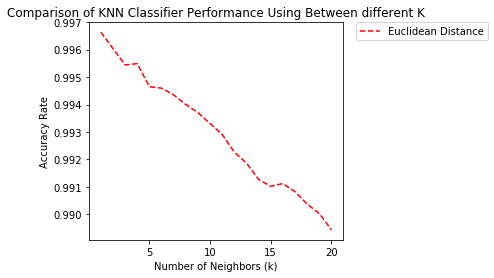

In [136]:

k = np.array(range(1, 21))
euc = np.array(euc_accuracy)
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax1.set_title("Comparison of KNN Classifier Performance Using Between different K")
ax1.set_xlabel('Number of Neighbors (k)')
ax1.set_ylabel('Accuracy Rate')
plt.plot(k, euc, 'r--', label='Euclidean Distance')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
pipeline_4 = Pipeline([
    ('SVD', tag_svd),
    ('gbr', GradientBoostingRegressor(learning_rate = 0.1, max_features = 20)) 
])  

p4_scores = cross_val_score(pipeline_4, X_train, y_train,
                         scoring="neg_mean_squared_error", cv=kFolds)
p4_rmse_scores = np.sqrt(-p4_scores)
display_scores(p4_rmse_scores)

#paired t-test; two-tailed p-value (aka two-sided)
(t_score, p_value) = stats.ttest_rel(p1_rmse_scores, p4_rmse_scores)
print("The p-value is %0.5f for a t-score of %0.5f." %(p_value, t_score))


if p_value > 0.05/2:  #Two sided t test 
    print('There is no significant difference between the two machine learning pipelines (Accept H0)')
else:
    print('The two machine learning pipelines are different (reject H0) \n(t_score, p_value) = (%.2f, %.5f)'%(t_score, p_value) )
    if t_score < 0.0:
        print('Pipeline 1 KNN is better than Pipeline 4 GBR')
    else:
        print('Pipeline 4 GBR is better than Pipeline 1 KNN')

# Deep Learning with Keras

## Basic deep learning

In [9]:
import tensorflow as tf
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
import pydot
from IPython.display import SVG, display

from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


We will start by doing a train-test split on the data, and using SVD to reduce the feature set.

In [13]:
X = transformed_data.copy()
X = X.drop(['userId','movieId','rating'],axis = 1)
X = tag_svd.fit_transform(X)
y = transformed_data.copy()
y = y['rating']



In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


We'll start with a basic one-layer model.

In [11]:

# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=25, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, activation='relu'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer="sgd", metrics=["mae"])
    return model

In [12]:
model_b = baseline_model()
model_b.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                260       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 271
Trainable params: 271
Non-trainable params: 0
_________________________________________________________________


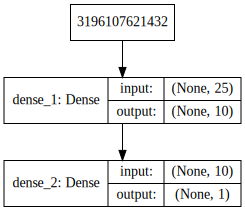

In [190]:
SVG(model_to_dot(model_b,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

Fit the model:

In [13]:

hist = model_b.fit(X_train, y_train, 
                       validation_data=(X_test, y_test), 
                       epochs=100, verbose=0)

Graph the MAE over the epochs:

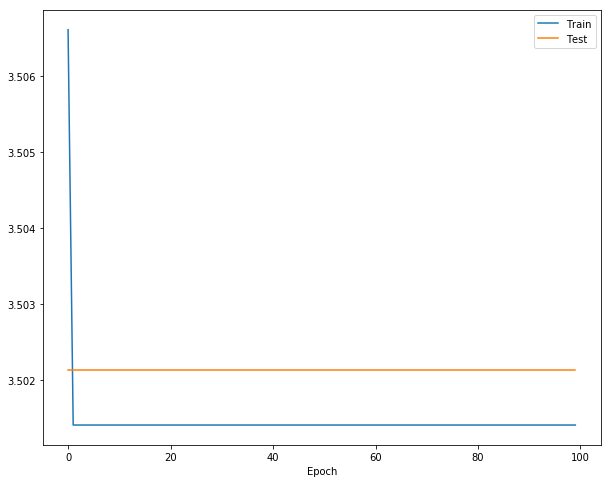

In [14]:
plt.figure(figsize=(10, 8))
plt.plot(hist.history["mean_absolute_error"], label="Train")
plt.plot(hist.history["val_mean_absolute_error"], label="Test")
plt.legend(frameon=True)
plt.xlabel("Epoch");

This does not appear to have worked. We will try adding a layer

In [15]:
def layered_model():
    # create model
    model = Sequential()
    model.add(Dense(15, input_dim=25, kernel_initializer='normal', activation='relu'))
    model.add(Dense(5, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer="sgd", metrics=["mae"])
    return model

In [17]:
model_l = layered_model()
model_l.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 15)                390       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 80        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 476
Trainable params: 476
Non-trainable params: 0
_________________________________________________________________


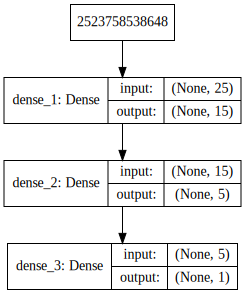

In [18]:
SVG(model_to_dot(model_l,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [21]:
start = time()
hist = model_l.fit(X_train, y_train, 
                       validation_data=(X_test, y_test), 
                       epochs=100, verbose=0)

test_time = time()-start

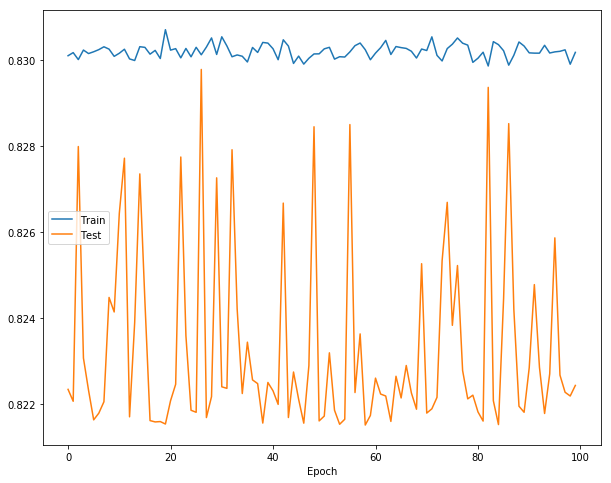

In [22]:
plt.figure(figsize=(10, 8))
plt.plot(hist.history["mean_absolute_error"], label="Train")
plt.plot(hist.history["val_mean_absolute_error"], label="Test")
plt.legend(frameon=True)
plt.xlabel("Epoch"); 

That accuracy is much more in line with what we had before. Now that we have a working model, let's start logging the results

In [23]:
y_pred = model_l.predict(X_test)

In [24]:
model_log_deep = pd.DataFrame(columns=['Model','Trainable params','layers','epochs','Accuracy (RMSE)','Time (s)','Notes']) 
model_log_deep.loc[len(model_log_deep)] = ['Keras deep learning layered model'
                                 ,476
                                 ,len(model_l.layers)
                                 ,len(hist.history['mean_absolute_error'])
                                 ,np.sqrt(mean_squared_error(y_test, y_pred))
                                 ,test_time
                                 ,'']

model_log_deep

,Model,Trainable params,layers,epochs,Accuracy (RMSE),Time (s),Notes
0,Keras deep learning layered model,476,3,100,1.036326,503.761462,


Let's see if more epochs makes a difference: 

In [26]:
model_l = layered_model()
start = time()
hist = model_l.fit(X_train, y_train, 
                       validation_data=(X_test, y_test), 
                       epochs=200, verbose=0)
test_time = time()-start
y_pred = model_l.predict(X_test)
model_log_deep.loc[len(model_log_deep)] = ['Keras deep learning layered model'
                                 ,476
                                 ,len(model_l.layers)
                                 ,len(hist.history['mean_absolute_error'])
                                 ,np.sqrt(mean_squared_error(y_test, y_pred))
                                 ,test_time
                                 ,'']

model_log_deep

,Model,Trainable params,layers,epochs,Accuracy (RMSE),Time (s),Notes
0,Keras deep learning layered model,476,3,100,1.036326,503.761462,
1,Keras deep learning layered model,476,3,200,1.035968,1051.938516,


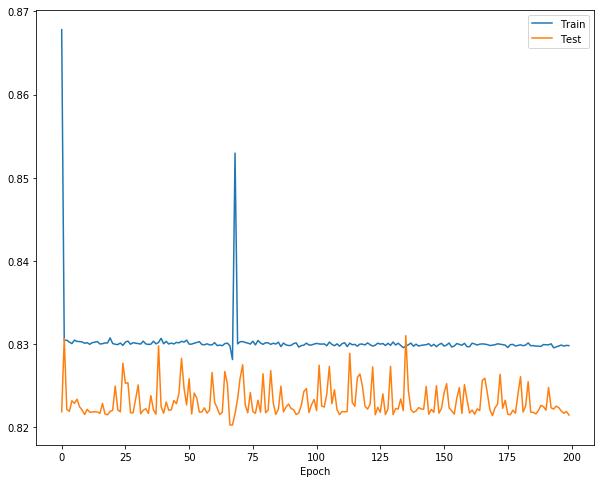

In [27]:
plt.figure(figsize=(10, 8))
plt.plot(hist.history["mean_absolute_error"], label="Train")
plt.plot(hist.history["val_mean_absolute_error"], label="Test")
plt.legend(frameon=True)
plt.xlabel("Epoch"); 

It made a little bit of difference. Now let's try adding more regressors to the middle layer:

In [31]:
def big_layered_model():
    # create model
    model = Sequential()
    model.add(Dense(15, input_dim=25, kernel_initializer='normal', activation='relu'))
    model.add(Dense(8, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer="sgd", metrics=["mae"])
    return model
model_lb = big_layered_model()
model_lb.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 15)                390       
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 128       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 9         
Total params: 527
Trainable params: 527
Non-trainable params: 0
_________________________________________________________________


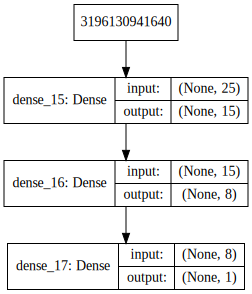

In [192]:
SVG(model_to_dot(model_lb,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [32]:
start = time()
hist = model_lb.fit(X_train, y_train, 
                       validation_data=(X_test, y_test), 
                       epochs=100, verbose=0)
test_time = time()-start
y_pred = model_lb.predict(X_test)
model_log_deep.loc[len(model_log_deep)] = ['Keras deep learning layered model'
                                 ,527
                                 ,len(model_lb.layers)
                                 ,len(hist.history['mean_absolute_error'])
                                 ,np.sqrt(mean_squared_error(y_test, y_pred))
                                 ,test_time
                                 ,'']

model_log_deep

,Model,Trainable params,layers,epochs,Accuracy (RMSE),Time (s),Notes
0,Keras deep learning layered model,476,3,100,1.036326,503.761462,
1,Keras deep learning layered model,476,3,200,1.035968,1051.938516,
2,Keras deep learning layered model,527,3,100,1.037158,563.804524,


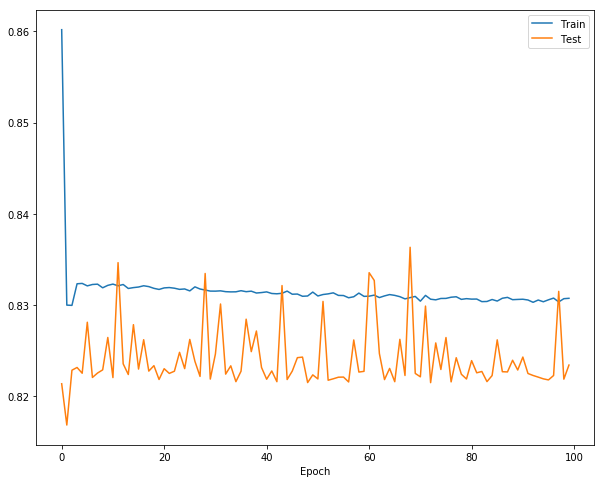

In [33]:
plt.figure(figsize=(10, 8))
plt.plot(hist.history["mean_absolute_error"], label="Train")
plt.plot(hist.history["val_mean_absolute_error"], label="Test")
plt.legend(frameon=True)
plt.xlabel("Epoch"); 

Now we'll add a fourth layer:

In [34]:
def four_layered_model():
    # create model
    model = Sequential()
    model.add(Dense(20, input_dim=25, kernel_initializer='normal', activation='relu'))
    model.add(Dense(15, kernel_initializer='normal', activation='relu'))
    model.add(Dense(8, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer="sgd", metrics=["mae"])
    return model
model_fl = four_layered_model()
model_fl.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 20)                520       
_________________________________________________________________
dense_19 (Dense)             (None, 15)                315       
_________________________________________________________________
dense_20 (Dense)             (None, 8)                 128       
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 9         
Total params: 972
Trainable params: 972
Non-trainable params: 0
_________________________________________________________________


We'll use a pipeline:

In [47]:
start = time()
kr = KerasRegressor(build_fn=four_layered_model, nb_epoch=100)

k_pipeline = Pipeline([
    ('kr', kr)
])

k_pipeline.fit(X_train, y_train)
test_time = time()-start

Epoch 1/1
80668/80668 [==============================] - 7s 81us/step - loss: 1.2181 - mean_absolute_error: 0.8688


In [45]:
y_pred = k_pipeline.predict(X_test)

In [46]:
np.sqrt(mean_squared_error(y_test, y_pred))

1.0242931368740085

In [48]:
model_log_deep.loc[len(model_log_deep)] = ['Keras deep learning with pipeline'
                                 ,972
                                 ,len(model_fl.layers)
                                 ,len(hist.history['mean_absolute_error'])
                                 ,np.sqrt(mean_squared_error(y_test, y_pred))
                                 ,test_time
                                 ,'']

model_log_deep

,Model,Trainable params,layers,epochs,Accuracy (RMSE),Time (s),Notes
0,Keras deep learning layered model,476,3,100,1.036326,503.761462,
1,Keras deep learning layered model,476,3,200,1.035968,1051.938516,
2,Keras deep learning layered model,527,3,100,1.037158,563.804524,
3,Keras deep learning layered model,527,4,100,1.021244,578.127636,
4,Keras deep learning with pipeline,972,4,100,1.024293,7.588982,


In [58]:
param_grid = {
        'kr__nb_epoch': [100,200,300,400], 
    }

start = time()
k_pipeline = Pipeline([ 
    ('kr', KerasRegressor(build_fn = four_layered_model, nb_epoch=100))
])   


grid_search = GridSearchCV(k_pipeline, param_grid, cv=5,
                           scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)
test_time = time()-start

Epoch 1/1
64534/64534 [==============================] - 6s 98us/step - loss: 1.2484 - mean_absolute_error: 0.8774
Epoch 1/1
64534/64534 [==============================] - 7s 104us/step - loss: 1.2486 - mean_absolute_error: 0.8757 0s - loss: 1.2549 - mean_absolute_error: 0
Epoch 1/1
64534/64534 [==============================] - 7s 102us/step - loss: 1.2541 - mean_absolute_error: 0.8788
Epoch 1/1
64535/64535 [==============================] - 7s 104us/step - loss: 1.2437 - mean_absolute_error: 0.8739 0s - loss: 1.2620 - mean_absolute_
Epoch 1/1
64535/64535 [==============================] - 7s 106us/step - loss: 1.2528 - mean_absolute_error: 0.8775
Epoch 1/1
64534/64534 [==============================] - 7s 108us/step - loss: 1.2436 - mean_absolute_error: 0.8761
Epoch 1/1
64534/64534 [==============================] - 7s 110us/step - loss: 1.2547 - mean_absolute_error: 0.8756
Epoch 1/1
64534/64534 [==============================] - 7s 113us/step - loss: 1.2468 - mean_absolute_error: 0.

Use SVG to draw a diagram of the model.

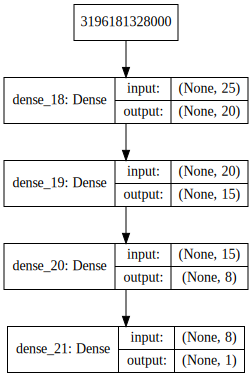

In [82]:
SVG(model_to_dot(model_fl,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

## Flatten/embed method

Keras can do some of the data pre-processing that we did using the Flatten and Embed methods. First we need to make our userIDs and movieIds sequential:

In [24]:
ratings_small_cat = ratings_small.copy()
ratings_small_cat.userId = ratings_small_cat.userId.astype('category').cat.codes.values
ratings_small_cat.movieId = ratings_small_cat.movieId.astype('category').cat.codes.values
Xr_train, Xr_test = train_test_split(ratings_small_cat, test_size=0.2)

We can use Keras to "flatten" the data, which is like pivoting the data. We'll need as many embeddings as there are movies, plus one for "none". When doing the embedding, we can set a number of latent factors; we'll start with three.

In [106]:
import keras
movie_inp = keras.layers.Input(shape=[1],name='movie')
movie_emb = keras.layers.Embedding(len(ratings_small_cat.movieId.unique()) + 1, 3)(movie_inp)
movie_vec = keras.layers.Flatten(name = 'movie_flat')(movie_emb)

We'll do the same thing for Users

In [108]:
user_inp = keras.layers.Input(shape=[1],name='user')
user_emb = keras.layers.Embedding(len(ratings_small_cat.userId.unique()) + 1, 3)(user_inp)
user_vec = keras.layers.Flatten(name = 'user_flat')(user_emb)

Now that we have both, we can take a dot product of he movies vector and the users vector. We'll build a keras model using SGD 

In [109]:
inputs=[movie_vec, user_vec]
prod = keras.layers.dot(inputs, axes=[1,1])
model = keras.Model([user_inp, movie_inp], prod)
model.compile('sgd', 'mse')

Draw the model with SVG:

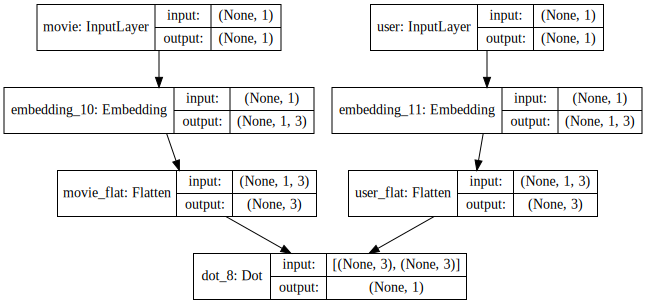

In [110]:
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [111]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
movie (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
user (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 1, 3)         29175       movie[0][0]                      
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 1, 3)         1833        user[0][0]                       
__________________________________________________________________________________________________
movie_flat

In [115]:


history = model.fit([Xr_train.userId, Xr_train.movieId], Xr_train.rating, epochs=25)


Epoch 1/25
80668/80668 [==============================] - 11s 141us/step - loss: 2.8067
Epoch 2/25
80668/80668 [==============================] - 11s 142us/step - loss: 2.6823
Epoch 3/25
80668/80668 [==============================] - 11s 141us/step - loss: 2.5693
Epoch 4/25
80668/80668 [==============================] - 11s 142us/step - loss: 2.4661
Epoch 5/25
80668/80668 [==============================] - ETA: 0s - loss: 2.3721- ETA: 0s -  - 11s 140us/step - loss: 2.3717
Epoch 6/25
80668/80668 [==============================] - 11s 140us/step - loss: 2.2849
Epoch 7/25
80668/80668 [==============================] - 11s 140us/step - loss: 2.2050
Epoch 8/25
80668/80668 [==============================] - 12s 143us/step - loss: 2.1311
Epoch 9/25
80668/80668 [==============================] - 11s 140us/step - loss: 2.0626
Epoch 10/25
80668/80668 [==============================] - 11s 140us/step - loss: 1.9991
Epoch 11/25
80668/80668 [==============================] - 11s 140us/step - loss: 

In [25]:
def flatten_model(movie_latent, user_latent):
    movie_inp = keras.layers.Input(shape=[1],name='movie')
    movie_emb = keras.layers.Embedding(len(ratings_small_cat.movieId.unique()) + 1, movie_latent)(movie_inp)
    movie_vec = keras.layers.Flatten(name = 'movie_flat')(movie_emb)
    user_inp = keras.layers.Input(shape=[1],name='user')
    user_emb = keras.layers.Embedding(len(ratings_small_cat.userId.unique()) + 1, user_latent)(user_inp)
    user_vec = keras.layers.Flatten(name = 'user_flat')(user_emb)
    inputs=[movie_vec, user_vec]
    prod = keras.layers.dot(inputs, axes=[1,1])
    model = keras.Model([user_inp, movie_inp], prod)
    model.compile('sgd', 'mse')
    return model

In [141]:
y_preds = model.predict([Xr_test['userId'],Xr_test['movieId']])

In [143]:
model_log_deep.loc[len(model_log_deep)] = ['Keras with split user/movie'
                                 ,31008
                                 ,len(model.layers)
                                 ,len(hist.history['mean_absolute_error'])
                                 ,np.sqrt(mean_squared_error(Xr_test['rating'], y_preds))
                                 ,test_time
                                 ,'']

model_log_deep

,Model,Trainable params,layers,epochs,Accuracy (RMSE),Time (s),Notes
0,Keras deep learning layered model,476,3,100,1.036326,503.761462,
1,Keras deep learning layered model,476,3,200,1.035968,1051.938516,
2,Keras deep learning layered model,527,3,100,1.037158,563.804524,
3,Keras deep learning layered model,527,4,100,1.021244,578.127636,
4,Keras deep learning with pipeline,972,4,100,1.024293,7.588982,
5,Keras with split user/movie,31008,7,100,1.361389,266.967594,


Now we'll gridsearch to find the optimal number of latent parameters:

In [151]:
for movie_latent in [1,3,5,10, 20]:
     
        start = time()
        model = flatten_model(movie_latent, movie_latent)
        history = model.fit([Xr_train.userId, Xr_train.movieId], Xr_train.rating, epochs=100)
        test_time = time()-start

        y_preds = model.predict([Xr_test['userId'],Xr_test['movieId']])
        

        model_log_deep.loc[len(model_log_deep)] = ['Keras with latent user/movie layer'
                                 ,0
                                 ,len(model.layers)
                                 ,100
                                 ,np.sqrt(mean_squared_error(Xr_test['rating'], y_preds))
                                 ,test_time
                                 ,str(movie_latent) + '/' + str(user_latent)]
model_log_deep

Epoch 1/100
80668/80668 [==============================] - 15s 186us/step - loss: 13.3317
Epoch 2/100
80668/80668 [==============================] - 12s 153us/step - loss: 13.3317
Epoch 3/100
80668/80668 [==============================] - 12s 153us/step - loss: 13.3317
Epoch 4/100
80668/80668 [==============================] - 12s 153us/step - loss: 13.3317
Epoch 5/100
80668/80668 [==============================] - 12s 153us/step - loss: 13.3316
Epoch 6/100
80668/80668 [==============================] - 12s 153us/step - loss: 13.3316
Epoch 7/100
80668/80668 [==============================] - 12s 153us/step - loss: 13.3316
Epoch 8/100
80668/80668 [==============================] - 12s 153us/step - loss: 13.3316
Epoch 9/100
80668/80668 [==============================] - 12s 153us/step - loss: 13.3315
Epoch 10/100
80668/80668 [==============================] - 12s 153us/step - loss: 13.3315
Epoch 11/100
80668/80668 [==============================] - 12s 153us/step - loss: 13.3314
Epoch 12

80668/80668 [==============================] - 15s 183us/step - loss: 1.0770
Epoch 82/100
80668/80668 [==============================] - 15s 182us/step - loss: 1.0641
Epoch 83/100
80668/80668 [==============================] - 15s 182us/step - loss: 1.05170s - los
Epoch 84/100
80668/80668 [==============================] - 15s 182us/step - loss: 1.0397
Epoch 85/100
80668/80668 [==============================] - 15s 182us/step - loss: 1.0280
Epoch 86/100
80668/80668 [==============================] - 15s 182us/step - loss: 1.0167
Epoch 87/100
80668/80668 [==============================] - 15s 182us/step - loss: 1.0058
Epoch 88/100
80668/80668 [==============================] - 15s 182us/step - loss: 0.9953
Epoch 89/100
80668/80668 [==============================] - 15s 185us/step - loss: 0.9850
Epoch 90/100
80668/80668 [==============================] - 15s 186us/step - loss: 0.9751
Epoch 91/100
80668/80668 [==============================] - 15s 183us/step - loss: 0.9655
Epoch 92/100
80

80668/80668 [==============================] - 17s 215us/step - loss: 1.4338
Epoch 63/100
80668/80668 [==============================] - 17s 209us/step - loss: 1.4056
Epoch 64/100
80668/80668 [==============================] - 17s 206us/step - loss: 1.3787
Epoch 65/100
80668/80668 [==============================] - 17s 206us/step - loss: 1.3531
Epoch 66/100
80668/80668 [==============================] - 17s 207us/step - loss: 1.3285
Epoch 67/100
80668/80668 [==============================] - 17s 206us/step - loss: 1.3050
Epoch 68/100
80668/80668 [==============================] - 17s 206us/step - loss: 1.2824
Epoch 69/100
80668/80668 [==============================] - 17s 206us/step - loss: 1.2608
Epoch 70/100
80668/80668 [==============================] - 17s 206us/step - loss: 1.2400
Epoch 71/100
80668/80668 [==============================] - 17s 210us/step - loss: 1.2201
Epoch 72/100
80668/80668 [==============================] - 18s 220us/step - loss: 1.2009
Epoch 73/100
80668/8066

,Model,Trainable params,layers,epochs,Accuracy (RMSE),Time (s),Notes
0,Keras deep learning layered model,476,3,100,1.036326,503.761462,
1,Keras deep learning layered model,476,3,200,1.035968,1051.938516,
2,Keras deep learning layered model,527,3,100,1.037158,563.804524,
3,Keras deep learning layered model,527,4,100,1.021244,578.127636,
4,Keras deep learning with pipeline,972,4,100,1.024293,7.588982,
5,Keras with split user/movie,31008,7,100,1.361389,266.967594,
6,Keras with latent user/movie layer,0,7,100,1.212155,1032.170360,1/1
7,Keras with latent user/movie layer,0,7,100,1.233652,1237.162716,1/3
8,Keras with latent user/movie layer,0,7,100,1.200567,1477.991524,3/3
9,Keras with latent user/movie layer,0,7,100,1.204553,1608.590939,5/3


Adding more latent parameters sems to help, but there's diminishing returns.

### Add dropout layers

We're going to make two changes to the model. First, we're going to add dropouts to reduce the number of predictors. Also we're going to concatenate the movies and users. This will allow isto use a different number of latents for both movies and users.

In [74]:
def flatten_model_with_dropouts(movie_latent, user_latent):
    movie_inp = keras.layers.Input(shape=[1],name='movie')
    movie_emb = keras.layers.Embedding(len(ratings_small_cat.movieId.unique()) + 1, movie_latent)(movie_inp)
    movie_vec = keras.layers.Flatten(name = 'movie_flat')(movie_emb)
    movie_vec = keras.layers.Dropout(0.2)(movie_vec)
    
    user_inp = keras.layers.Input(shape=[1],name='user')
    user_emb = keras.layers.Embedding(len(ratings_small_cat.userId.unique()) + 1, user_latent)(user_inp)
    user_vec = keras.layers.Flatten(name = 'user_flat')(user_emb)
    user_vec = keras.layers.Dropout(0.2)(user_vec)
    
    inputs=[movie_vec, user_vec]
    movie_user = keras.layers.concatenate(inputs, axis = 1)
    L_1 = keras.layers.Dense(50)(movie_user)
    L_2 = keras.layers.Dense(20)(L_1) 
    
    prod = keras.layers.Dense(1,activation = 'relu')(L_2)
    model = keras.Model([user_inp, movie_inp], prod)
    model.compile('sgd', 'mse')
    return model

In [21]:
import keras

In [27]:
start = time()
model = flatten_model_with_dropouts(3, 6)
history = model.fit([Xr_train.userId, Xr_train.movieId], Xr_train.rating, epochs=100)
test_time = time()-start

Epoch 1/100
80668/80668 [==============================] - 8s 97us/step - loss: 1.0006
Epoch 2/100
80668/80668 [==============================] - 7s 81us/step - loss: 0.8818
Epoch 3/100
80668/80668 [==============================] - 7s 82us/step - loss: 0.8255
Epoch 4/100
80668/80668 [==============================] - 7s 81us/step - loss: 0.7881
Epoch 5/100
80668/80668 [==============================] - 7s 82us/step - loss: 0.7673
Epoch 6/100
80668/80668 [==============================] - 7s 82us/step - loss: 0.7513
Epoch 7/100
80668/80668 [==============================] - 7s 81us/step - loss: 0.7388
Epoch 8/100
80668/80668 [==============================] - 6s 80us/step - loss: 0.7321
Epoch 9/100
80668/80668 [==============================] - 7s 81us/step - loss: 0.7241
Epoch 10/100
80668/80668 [==============================] - 7s 81us/step - loss: 0.7167
Epoch 11/100
80668/80668 [==============================] - 6s 80us/step - loss: 0.7126
Epoch 12/100
80668/80668 [===============

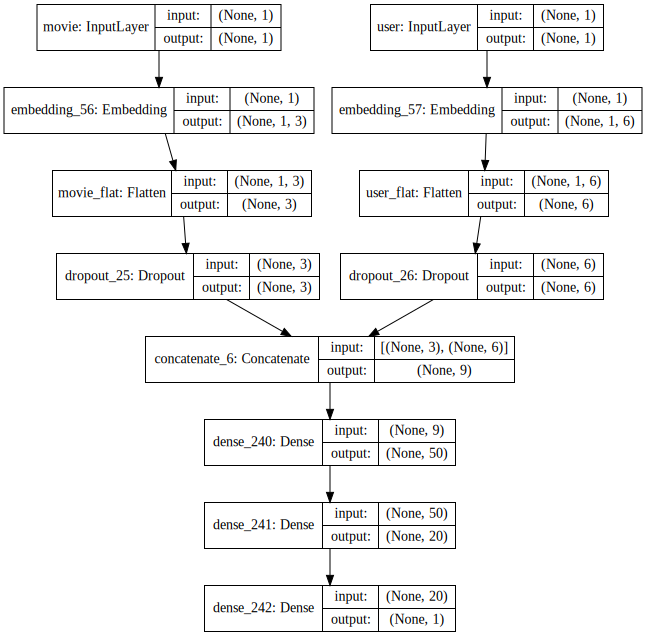

In [183]:
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [182]:
model_log_deep.loc[len(model_log_deep)] = ['Keras with dropout/merge and latent user/movie layer'
                                 ,0
                                 ,len(model.layers)
                                 ,100
                                 ,np.sqrt(mean_squared_error(Xr_test['rating'], y_preds))
                                 ,test_time
                                 ,str(3) + '/' + str(6)]
model_log_deep

,Model,Trainable params,layers,epochs,Accuracy (RMSE),Time (s),Notes
0,Keras deep learning layered model,476,3,100,1.036326,503.761462,
1,Keras deep learning layered model,476,3,200,1.035968,1051.938516,
2,Keras deep learning layered model,527,3,100,1.037158,563.804524,
3,Keras deep learning layered model,527,4,100,1.021244,578.127636,
4,Keras deep learning with pipeline,972,4,100,1.024293,7.588982,
5,Keras with split user/movie,31008,7,100,1.361389,266.967594,
6,Keras with latent user/movie layer,0,7,100,1.212155,1032.170360,1/1
7,Keras with latent user/movie layer,0,7,100,1.233652,1237.162716,1/3
8,Keras with latent user/movie layer,0,7,100,1.200567,1477.991524,3/3
9,Keras with latent user/movie layer,0,7,100,1.204553,1608.590939,5/3


RMSE is dramatically better with this approach.

In [184]:
for movie_latent in [5,10, 20]:
    for user_latent in [5,10, 20]:
        start = time()
        model = flatten_model_with_dropouts(movie_latent,user_latent)
        history = model.fit([Xr_train.userId, Xr_train.movieId], Xr_train.rating, epochs=100)
        test_time = time()-start

        y_preds = model.predict([Xr_test['userId'],Xr_test['movieId']])
        

        model_log_deep.loc[len(model_log_deep)] = ['Keras with latent user/movie layer'
                                 ,0
                                 ,len(model.layers)
                                 ,100
                                 ,np.sqrt(mean_squared_error(Xr_test['rating'], y_preds))
                                 ,test_time
                                 ,str(movie_latent) + '/' + str(user_latent)]
model_log_deep

Epoch 1/100
80668/80668 [==============================] - 21s 260us/step - loss: 1.0354
Epoch 2/100
80668/80668 [==============================] - 17s 215us/step - loss: 0.8986
Epoch 3/100
80668/80668 [==============================] - 17s 215us/step - loss: 0.8357
Epoch 4/100
80668/80668 [==============================] - 17s 216us/step - loss: 0.7948
Epoch 5/100
80668/80668 [==============================] - 17s 215us/step - loss: 0.7702
Epoch 6/100
80668/80668 [==============================] - 17s 216us/step - loss: 0.7546
Epoch 7/100
80668/80668 [==============================] - 17s 216us/step - loss: 0.7403
Epoch 8/100
80668/80668 [==============================] - 17s 215us/step - loss: 0.7344
Epoch 9/100
80668/80668 [==============================] - 17s 216us/step - loss: 0.7230
Epoch 10/100
80668/80668 [==============================] - 17s 216us/step - loss: 0.7164
Epoch 11/100
80668/80668 [==============================] - 17s 217us/step - loss: 0.7127
Epoch 12/100
80668/

80668/80668 [==============================] - 16s 203us/step - loss: 0.6504
Epoch 93/100
80668/80668 [==============================] - 16s 202us/step - loss: 0.6505
Epoch 94/100
80668/80668 [==============================] - 16s 203us/step - loss: 0.6501
Epoch 95/100
80668/80668 [==============================] - 16s 202us/step - loss: 0.6497
Epoch 96/100
80668/80668 [==============================] - 16s 203us/step - loss: 0.6494
Epoch 97/100
80668/80668 [==============================] - 16s 202us/step - loss: 0.6495
Epoch 98/100
80668/80668 [==============================] - 16s 203us/step - loss: 0.6503
Epoch 99/100
80668/80668 [==============================] - 16s 201us/step - loss: 0.65010s - loss: 0.65
Epoch 100/100
80668/80668 [==============================] - 16s 203us/step - loss: 0.6500
Epoch 1/100
80668/80668 [==============================] - 21s 257us/step - loss: 0.9917
Epoch 2/100
80668/80668 [==============================] - 17s 214us/step - loss: 0.8645
Epoch 3/1

80668/80668 [==============================] - 18s 226us/step - loss: 0.6449
Epoch 84/100
80668/80668 [==============================] - 18s 226us/step - loss: 0.6458
Epoch 85/100
80668/80668 [==============================] - 18s 226us/step - loss: 0.6458
Epoch 86/100
80668/80668 [==============================] - 18s 226us/step - loss: 0.6450
Epoch 87/100
80668/80668 [==============================] - 18s 227us/step - loss: 0.6458
Epoch 88/100
80668/80668 [==============================] - 18s 227us/step - loss: 0.6437
Epoch 89/100
80668/80668 [==============================] - 18s 226us/step - loss: 0.6461
Epoch 90/100
80668/80668 [==============================] - 18s 226us/step - loss: 0.6450
Epoch 91/100
80668/80668 [==============================] - 18s 226us/step - loss: 0.6434
Epoch 92/100
80668/80668 [==============================] - 18s 227us/step - loss: 0.6446
Epoch 93/100
80668/80668 [==============================] - 18s 227us/step - loss: 0.6444
Epoch 94/100
80668/8066

80668/80668 [==============================] - 18s 226us/step - loss: 0.6480
Epoch 66/100
80668/80668 [==============================] - 18s 226us/step - loss: 0.6474
Epoch 67/100
80668/80668 [==============================] - 18s 226us/step - loss: 0.6439
Epoch 68/100
80668/80668 [==============================] - 18s 226us/step - loss: 0.6463
Epoch 69/100
80668/80668 [==============================] - 18s 226us/step - loss: 0.6467
Epoch 70/100
80668/80668 [==============================] - 18s 227us/step - loss: 0.6447
Epoch 71/100
80668/80668 [==============================] - 18s 226us/step - loss: 0.6444
Epoch 72/100
80668/80668 [==============================] - 18s 226us/step - loss: 0.6461
Epoch 73/100
80668/80668 [==============================] - 18s 226us/step - loss: 0.6450
Epoch 74/100
80668/80668 [==============================] - 18s 226us/step - loss: 0.6450
Epoch 75/100
80668/80668 [==============================] - 18s 226us/step - loss: 0.6448
Epoch 76/100
80668/8066

80668/80668 [==============================] - 18s 222us/step - loss: 0.6487
Epoch 48/100
80668/80668 [==============================] - 18s 227us/step - loss: 0.6480
Epoch 49/100
80668/80668 [==============================] - 19s 239us/step - loss: 0.6472
Epoch 50/100
80668/80668 [==============================] - 18s 224us/step - loss: 0.6475
Epoch 51/100
80668/80668 [==============================] - 18s 222us/step - loss: 0.6465
Epoch 52/100
80668/80668 [==============================] - 18s 222us/step - loss: 0.6464
Epoch 53/100
80668/80668 [==============================] - 18s 222us/step - loss: 0.6467
Epoch 54/100
80668/80668 [==============================] - 18s 222us/step - loss: 0.6443
Epoch 55/100
80668/80668 [==============================] - ETA: 0s - loss: 0.646 - 18s 223us/step - loss: 0.6459
Epoch 56/100
80668/80668 [==============================] - 18s 225us/step - loss: 0.6458
Epoch 57/100
80668/80668 [==============================] - 18s 225us/step - loss: 0.6449

80668/80668 [==============================] - 22s 269us/step - loss: 0.6576
Epoch 28/100
80668/80668 [==============================] - 22s 270us/step - loss: 0.6565
Epoch 29/100
80668/80668 [==============================] - 22s 277us/step - loss: 0.6564
Epoch 30/100
80668/80668 [==============================] - 22s 276us/step - loss: 0.6556
Epoch 31/100
80668/80668 [==============================] - 22s 275us/step - loss: 0.6529
Epoch 32/100
80668/80668 [==============================] - 22s 277us/step - loss: 0.6533
Epoch 33/100
80668/80668 [==============================] - 22s 270us/step - loss: 0.6535
Epoch 34/100
80668/80668 [==============================] - 22s 271us/step - loss: 0.6517
Epoch 35/100
80668/80668 [==============================] - 22s 271us/step - loss: 0.6521
Epoch 36/100
80668/80668 [==============================] - 22s 269us/step - loss: 0.6499
Epoch 37/100
80668/80668 [==============================] - 22s 270us/step - loss: 0.6513
Epoch 38/100
80668/8066

,Model,Trainable params,layers,epochs,Accuracy (RMSE),Time (s),Notes
0,Keras deep learning layered model,476,3,100,1.036326,503.761462,
1,Keras deep learning layered model,476,3,200,1.035968,1051.938516,
2,Keras deep learning layered model,527,3,100,1.037158,563.804524,
3,Keras deep learning layered model,527,4,100,1.021244,578.127636,
4,Keras deep learning with pipeline,972,4,100,1.024293,7.588982,
5,Keras with split user/movie,31008,7,100,1.361389,266.967594,
6,Keras with latent user/movie layer,0,7,100,1.212155,1032.170360,1/1
7,Keras with latent user/movie layer,0,7,100,1.233652,1237.162716,1/3
8,Keras with latent user/movie layer,0,7,100,1.200567,1477.991524,3/3
9,Keras with latent user/movie layer,0,7,100,1.204553,1608.590939,5/3


In [185]:
model_log_deep

,Model,Trainable params,layers,epochs,Accuracy (RMSE),Time (s),Notes
0,Keras deep learning layered model,476,3,100,1.036326,503.761462,
1,Keras deep learning layered model,476,3,200,1.035968,1051.938516,
2,Keras deep learning layered model,527,3,100,1.037158,563.804524,
3,Keras deep learning layered model,527,4,100,1.021244,578.127636,
4,Keras deep learning with pipeline,972,4,100,1.024293,7.588982,
5,Keras with split user/movie,31008,7,100,1.361389,266.967594,
6,Keras with latent user/movie layer,0,7,100,1.212155,1032.170360,1/1
7,Keras with latent user/movie layer,0,7,100,1.233652,1237.162716,1/3
8,Keras with latent user/movie layer,0,7,100,1.200567,1477.991524,3/3
9,Keras with latent user/movie layer,0,7,100,1.204553,1608.590939,5/3


In [76]:
def flatten_model_with_3_dropouts(movie_latent, user_latent):
    movie_inp = keras.layers.Input(shape=[1],name='movie')
    movie_emb = keras.layers.Embedding(len(ratings_small_cat.movieId.unique()) + 1, movie_latent)(movie_inp)
    movie_vec = keras.layers.Flatten(name = 'movie_flat')(movie_emb)
    movie_vec = keras.layers.Dropout(0.2)(movie_vec)
    
    user_inp = keras.layers.Input(shape=[1],name='user')
    user_emb = keras.layers.Embedding(len(ratings_small_cat.userId.unique()) + 1, user_latent)(user_inp)
    user_vec = keras.layers.Flatten(name = 'user_flat')(user_emb)
    user_vec = keras.layers.Dropout(0.2)(user_vec)
    
    inputs=[movie_vec, user_vec]
    movie_user = keras.layers.concatenate(inputs, axis = 1)
    L_1 = keras.layers.Dense(100)(movie_user)
    L_2 = keras.layers.Dense(40)(L_1) 
    D_2 = keras.layers.Dropout(0.4)(L_2)
    L_3 = keras.layers.Dense(10)(D_2)
    prod = keras.layers.Dense(1,activation = 'relu')(L_3)
    model = keras.Model([user_inp, movie_inp], prod)
    model.compile('sgd', 'mse')
    return model

In [187]:
start = time()
movie_latent = 10
user_latent = 10

model_f3 = flatten_model_with_3_dropouts(movie_latent,user_latent)
model_f3.fit([Xr_train.userId, Xr_train.movieId], Xr_train.rating, epochs=100)
test_time = time()-start

y_preds = model_f3.predict([Xr_test['userId'],Xr_test['movieId']])
        

model_log_deep.loc[len(model_log_deep)] = ['Keras with split and 3-layer neural net'
    ,0
    ,len(model.layers)
    ,100
    ,np.sqrt(mean_squared_error(Xr_test['rating'], y_preds))
    ,test_time
    ,str(movie_latent) + '/' + str(user_latent)]

Epoch 1/100
80668/80668 [==============================] - 26s 325us/step - loss: 1.0180
Epoch 2/100
80668/80668 [==============================] - 24s 299us/step - loss: 0.8597
Epoch 3/100
80668/80668 [==============================] - 27s 329us/step - loss: 0.8055
Epoch 4/100
80668/80668 [==============================] - 23s 284us/step - loss: 0.7772
Epoch 5/100
80668/80668 [==============================] - 22s 268us/step - loss: 0.7552
Epoch 6/100
80668/80668 [==============================] - 20s 251us/step - loss: 0.7410
Epoch 7/100
80668/80668 [==============================] - 21s 257us/step - loss: 0.7306
Epoch 8/100
80668/80668 [==============================] - 20s 242us/step - loss: 0.7215
Epoch 9/100
80668/80668 [==============================] - 20s 242us/step - loss: 0.7160
Epoch 10/100
80668/80668 [==============================] - 19s 241us/step - loss: 0.7108
Epoch 11/100
80668/80668 [==============================] - 20s 244us/step - loss: 0.7024
Epoch 12/100
80668/

In [188]:
model_log_deep

,Model,Trainable params,layers,epochs,Accuracy (RMSE),Time (s),Notes
0,Keras deep learning layered model,476,3,100,1.036326,503.761462,
1,Keras deep learning layered model,476,3,200,1.035968,1051.938516,
2,Keras deep learning layered model,527,3,100,1.037158,563.804524,
3,Keras deep learning layered model,527,4,100,1.021244,578.127636,
4,Keras deep learning with pipeline,972,4,100,1.024293,7.588982,
5,Keras with split user/movie,31008,7,100,1.361389,266.967594,
6,Keras with latent user/movie layer,0,7,100,1.212155,1032.170360,1/1
7,Keras with latent user/movie layer,0,7,100,1.233652,1237.162716,1/3
8,Keras with latent user/movie layer,0,7,100,1.200567,1477.991524,3/3
9,Keras with latent user/movie layer,0,7,100,1.204553,1608.590939,5/3


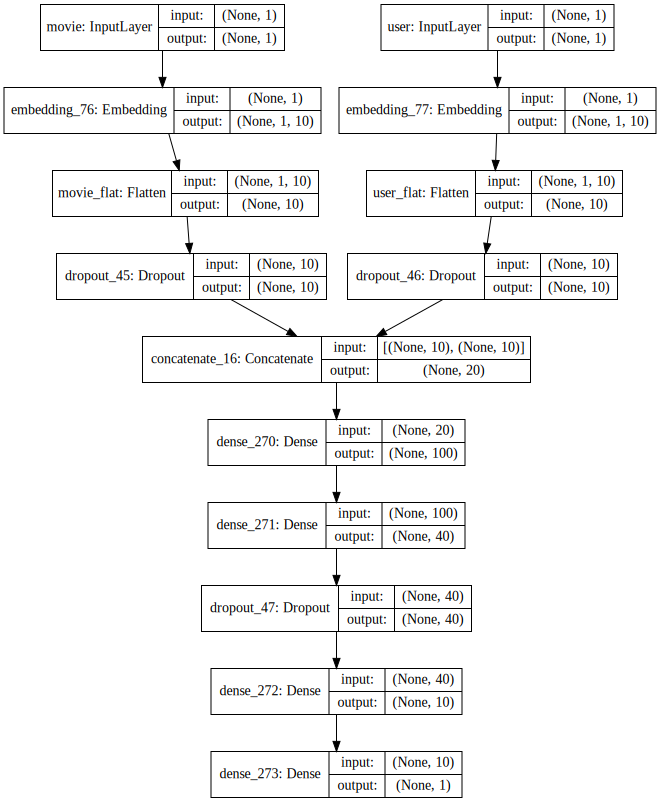

In [189]:
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

# Comparison of keras models

In [77]:
start = time()
movie_latent = 10
user_latent = 10

model_f3 = flatten_model_with_3_dropouts(movie_latent,user_latent)
model_f3.fit([Xr_train.userId, Xr_train.movieId], Xr_train.rating, epochs=100)
test_time = time()-start
 

Epoch 1/100
80668/80668 [==============================] - 10s 123us/step - loss: 1.0148
Epoch 2/100
80668/80668 [==============================] - 10s 118us/step - loss: 0.8686
Epoch 3/100
80668/80668 [==============================] - 9s 116us/step - loss: 0.8125
Epoch 4/100
80668/80668 [==============================] - 9s 116us/step - loss: 0.7781
Epoch 5/100
80668/80668 [==============================] - 9s 114us/step - loss: 0.7562
Epoch 6/100
80668/80668 [==============================] - 9s 117us/step - loss: 0.7421
Epoch 7/100
80668/80668 [==============================] - 9s 116us/step - loss: 0.7308
Epoch 8/100
80668/80668 [==============================] - 9s 117us/step - loss: 0.7221
Epoch 9/100
80668/80668 [==============================] - 9s 116us/step - loss: 0.7139
Epoch 10/100
80668/80668 [==============================] - 9s 116us/step - loss: 0.7102
Epoch 11/100
80668/80668 [==============================] - 9s 116us/step - loss: 0.7036
Epoch 12/100
80668/80668 [==

In [72]:
kfold = KFold(n_splits=10, shuffle=True)
flat_scores = []

Xr = Xr_train[['userId','movieId'] ]
Yr = Xr_train.rating

for train, test in kfold.split(Xr, Yr):
    Xrt = Xr.iloc[test]
    Yrt = Yr.iloc[test]
    model.fit([Xrt['userId'], Xrt['movieId']], Yrt, epochs=50, verbose=0)

    scores = model.evaluate([Xrt['userId'], Xrt['movieId']], Yrt, verbose=0) 
    flat_scores.append(scores)
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

0.61% (+/- 0.01%)


In [79]:
flat_scores 

[0.6171806777655539,
 0.6111175032450066,
 0.6165336597301236,
 0.6075840743372427,
 0.5918805266481003,
 0.6025298614790556,
 0.5982605160073275,
 0.607526194758171,
 0.6189656633686966,
 0.6099181192375843]

In [81]:
kfold = KFold(n_splits=10, shuffle=True)
flat_3_scores = []

Xr = Xr_train[['userId','movieId'] ]
Yr = Xr_train.rating

for train, test in kfold.split(Xr, Yr):
    Xrt = Xr.iloc[test]
    Yrt = Yr.iloc[test]
   # model.fit([Xrt['userId'], Xrt['movieId']], Yrt, epochs=50, verbose=0)

    scores = model.evaluate([Xrt['userId'], Xrt['movieId']], Yrt, verbose=0) 
    flat_3_scores.append(scores)
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

0.61% (+/- 0.01%)


In [82]:
flat_3_scores 

[0.6066709487459185,
 0.5967512600797178,
 0.6136886905793351,
 0.6116517154873711,
 0.613649970827248,
 0.6035269025652711,
 0.6118428121457479,
 0.6028779942084677,
 0.6116344903173383,
 0.6092010220965823]

In [83]:
(t_score, p_value) = stats.ttest_rel(flat_scores, flat_3_scores)
print("The p-value is %0.5f for a t-score of %0.5f." %(p_value, t_score))


if p_value > 0.05/2:  #Two sided t test 
    print('There is no significant difference between the networks (Accept H0)')
else:
    print('The two machine learning networkss are different (reject H0) \n(t_score, p_value) = (%.2f, %.5f)'%(t_score, p_value) )
    if t_score < 0.0:
        print('Network 1 (flatten with 2 dropouts) is better than Network 2 (flatten with 3 dropouts)')
    else:
        print('Network 2 (flatten with 3 dropouts) is better than Network 1 (flatten with 2 dropouts)')
 

The p-value is 0.99998 for a t-score of 0.00003.
There is no significant difference between the networks (Accept H0)


[Text(0, 0, 'Network 1'), Text(0, 0, 'Network 2 (3 d/o)')]

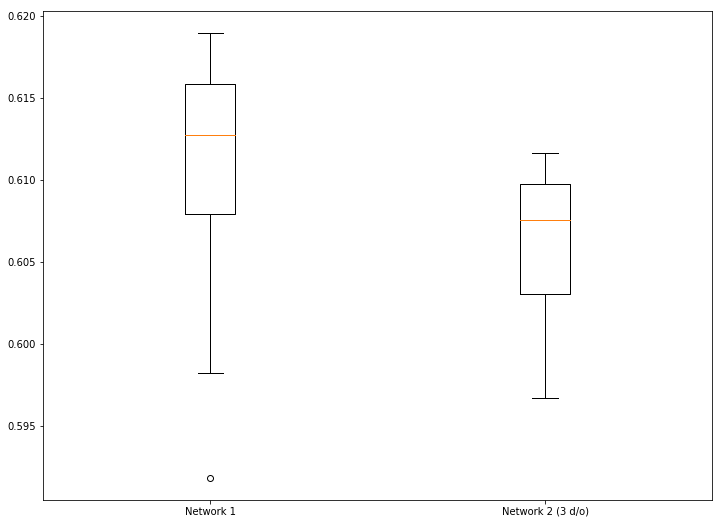

In [111]:
s = np.concatenate((flat_scores,flat_3_scores),0)
s.shape = (10,2)
fig = plt.figure(1, figsize=(12, 9))
ax = fig.add_subplot(111)
plt.boxplot(s)
ax.set_xticklabels(['Network 1', 'Network 2 (3 d/o)'])